## Imports

In [1]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np
import seaborn as sns
from math import floor
from itertools import compress, product
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report, silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

## Connect to neo4j

In [2]:
driver = GraphDatabase.driver("bolt://localhost", auth=("neo4j", "fotis"))

## Graph Descriptive Statistics

### in-Degree Centrality

In [3]:
with driver.session() as session:
    query = "CALL algo.degree.stream('Account', 'TRANSFER_TO', {direction: 'incoming'}) YIELD nodeId, score RETURN algo.asNode(nodeId).accountId AS Account_ID, score AS inDegree ORDER BY inDegree DESC"
    result = session.run(query)

df_in_degree_centrality = pd.DataFrame([r.values() for r in result], columns=result.keys())

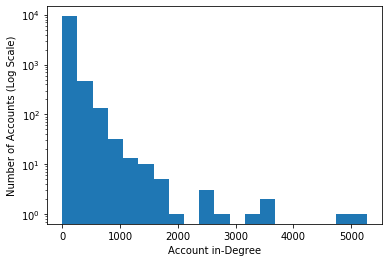

In [4]:
plt.hist(df_in_degree_centrality.inDegree, bins=20)
plt.yscale('log')
plt.ylabel('Number of Accounts (Log Scale)')
plt.xlabel('Account in-Degree')
plt.show()

### out-Degree Centrality

In [5]:
with driver.session() as session:
    query = "CALL algo.degree.stream('Account', 'TRANSFER_TO', {direction: 'outgoing'}) YIELD nodeId, score RETURN algo.asNode(nodeId).accountId AS Account_ID, score AS outDegree ORDER BY outDegree DESC"
    result = session.run(query)

df_out_degree_centrality = pd.DataFrame([r.values() for r in result], columns=result.keys())

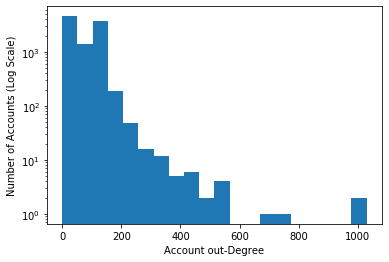

In [6]:
plt.hist(df_out_degree_centrality.outDegree, bins=20)
plt.yscale('log')
plt.ylabel('Number of Accounts (Log Scale)')
plt.xlabel('Account out-Degree')
plt.show()

### Harmonic Closeness Centrality

In [7]:
with driver.session() as session:
    query = "CALL algo.closeness.harmonic.stream('Account', 'TRANSFER_TO') YIELD nodeId, centrality RETURN algo.getNodeById(nodeId).accountId AS Account_ID, centrality ORDER BY centrality DESC"
    result = session.run(query)

df_harmonic_closeness_centrality = pd.DataFrame([r.values() for r in result], columns=result.keys())

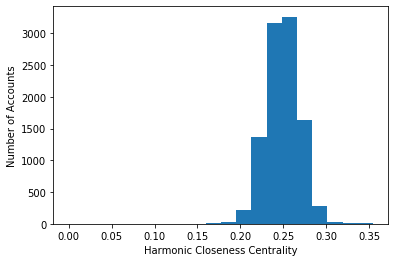

In [8]:
plt.hist(df_harmonic_closeness_centrality.centrality, bins=20)
plt.ylabel('Number of Accounts')
plt.xlabel('Harmonic Closeness Centrality')
plt.show()

### Betweenness Centrality

In [9]:
with driver.session() as session:
    query = "CALL algo.betweenness.stream('Account', 'TRANSFER_TO') YIELD nodeId, centrality RETURN algo.getNodeById(nodeId).accountId AS Account_ID, centrality ORDER BY centrality DESC"
    result = session.run(query)

df_betweenness_centrality = pd.DataFrame([r.values() for r in result], columns=result.keys())

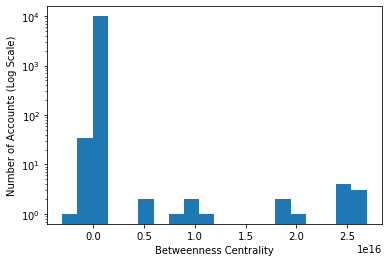

In [10]:
# Remove NaNs and -inf
df_betweenness_centrality_valid = df_betweenness_centrality[~df_betweenness_centrality.isin([np.nan, np.inf, -np.inf]).any(1)]

plt.hist(df_betweenness_centrality_valid.centrality, bins=20)
plt.yscale('log')
plt.ylabel('Number of Accounts (Log Scale)')
plt.xlabel('Betweenness Centrality')
plt.show()

## Create Dataframe of Transactions

In [11]:
with driver.session() as session:
    query = "match (a1:Account)-[r:TRANSFER_TO]->(a2:Account) return a1.accountId as Source_Account, a2.accountId as Destination_Account, r.amount as Amount, r.transferTimestamp as Timestamp, a1.isFraudulent as Fraudulent_Source_Flag, a2.isFraudulent as Fraudulent_Destination_Flag, r.isFraud as Fraud_Transaction_Flag"
    result = session.run(query)

main_df = pd.DataFrame([r.values() for r in result], columns=result.keys())

In [12]:
main_df['Timestamp'] = main_df['Timestamp'].apply(lambda x: x[:10])
main_df['Timestamp'] = pd.to_datetime(main_df['Timestamp'])
main_df = main_df.sort_values(by=['Source_Account', 'Timestamp'])

temp_df = main_df.groupby(['Source_Account'], as_index=False)['Timestamp'].count()
temp_df = temp_df.rename(columns={"Timestamp": "Transaction_Count_as_Sender"})

main_df = pd.merge(main_df, temp_df, how='left', on='Source_Account')

temp_df = main_df.groupby(['Destination_Account'], as_index=False)['Timestamp'].count()
temp_df = temp_df.rename(columns={"Destination_Account": "Source_Account", "Timestamp": "Transaction_Count_as_Recipient"})

main_df = pd.merge(main_df, temp_df, how='left', on='Source_Account')

### Binning of Transaction Amounts

In [13]:
def calc_amount_bins(amount):
    if (amount>=0 and amount <= 10): return 1
    if (amount>10 and amount <= 50): return 2
    if (amount>50 and amount <= 100): return 3
    if (amount>100 and amount <= 500): return 4
    if (amount>500 and amount <= 1000): return 5
    if (amount>1000 and amount <= 5000): return 6
    if (amount>5000 and amount <= 10000): return 7
    if (amount>10000 and amount <= 50000): return 8
    if (amount>50000 and amount <= 100000): return 9
    if (amount>100000): return 10

In [14]:
main_df['Amount_Bin'] = main_df.apply(lambda row: calc_amount_bins(float(row['Amount'])), axis=1)

In [15]:
main_df.head()

,Source_Account,Destination_Account,Amount,Timestamp,Fraudulent_Source_Flag,Fraudulent_Destination_Flag,Fraud_Transaction_Flag,Transaction_Count_as_Sender,Transaction_Count_as_Recipient,Amount_Bin
0,10,8843,414.71,2017-01-05,0,1,0,103,NaN,4
1,10,8843,414.71,2017-01-12,0,1,0,103,NaN,4
2,10,8843,414.71,2017-01-19,0,1,0,103,NaN,4
3,10,8843,414.71,2017-01-26,0,1,0,103,NaN,4
4,10,8843,414.71,2017-02-02,0,1,0,103,NaN,4


## Create Edgelist Files

In [16]:
filePath1 = "n2v_10K.edgelist"
filePath2 = "pbg_10K.edgelist"
if os.path.exists(filePath1):
    os.remove(filePath1)
if os.path.exists(filePath2):
    os.remove(filePath2)
# node2vec format
main_df[['Source_Account', 'Destination_Account', 'Amount']].to_csv (filePath1, sep=' ', index=None, header=False, encoding='utf-8')
# PBG format
main_df[['Source_Account', 'Amount', 'Destination_Account']].to_csv (filePath2, sep='\t', index=None, header=False, encoding='utf-8')

## Preprocessing of Nodes / Features

### Keep unique accounts with labels

In [17]:
tmp_df1 = main_df[['Source_Account', 'Fraudulent_Source_Flag']]
tmp_df2 = main_df[['Destination_Account', 'Fraudulent_Destination_Flag']]
tmp_df1 = tmp_df1.rename(columns={"Source_Account": "Account", "Fraudulent_Source_Flag": "Fraud"})
tmp_df2 = tmp_df2.rename(columns={"Destination_Account": "Account", "Fraudulent_Destination_Flag": "Fraud"})
accounts_df = pd.concat([tmp_df1, tmp_df2])

In [18]:
labeled_accounts_df = accounts_df.groupby('Account').agg('max')
labeled_accounts_df.reset_index(level=0, inplace=True)
labeled_accounts_df['Fraud'].value_counts()

0    8999
1    1000
Name: Fraud, dtype: int64

In [19]:
labeled_accounts_df.head()

,Account,Fraud
0,1,0
1,10,0
2,100,0
3,1000,0
4,1001,0


### Add features from the graph's descriptive statistics

In [20]:
df_in_degree_centrality = df_in_degree_centrality.rename(columns={"inDegree": "inDegree_Centrality", "Account_ID": "Account"})
df_out_degree_centrality = df_out_degree_centrality.rename(columns={"outDegree": "outDegree_Centrality", "Account_ID": "Account"})
df_harmonic_closeness_centrality = df_harmonic_closeness_centrality.rename(columns={"centrality": "Closeness_Centrality", "Account_ID": "Account"})
df_betweenness_centrality_valid = df_betweenness_centrality_valid.rename(columns={"centrality": "Betweenness_Centrality", "Account_ID": "Account"})

labeled_accounts_df = pd.merge(labeled_accounts_df, df_in_degree_centrality, how='left', on='Account')
labeled_accounts_df = pd.merge(labeled_accounts_df, df_out_degree_centrality, how='left', on='Account')
labeled_accounts_df = pd.merge(labeled_accounts_df, df_harmonic_closeness_centrality, how='left', on='Account')
labeled_accounts_df = pd.merge(labeled_accounts_df, df_betweenness_centrality_valid, how='left', on='Account')
# labeled_accounts_df['Account'] = labeled_accounts_df['Account'].astype(int)

### Add transaction count and percentage features

In [21]:
trans_s_df = main_df[['Source_Account', 'Transaction_Count_as_Sender']].drop_duplicates()
trans_s_df = trans_s_df.rename(columns={"Source_Account": "Account"})
labeled_accounts_df = pd.merge(labeled_accounts_df, trans_s_df, how='left', on='Account')

trans_r_df = main_df[['Source_Account', 'Transaction_Count_as_Recipient']].drop_duplicates()
trans_r_df = trans_r_df.rename(columns={"Source_Account": "Account"})
labeled_accounts_df = pd.merge(labeled_accounts_df, trans_r_df, how='left', on='Account')

In [22]:
for i in range(11):
    if i == 0: continue
    
    tmp_df = main_df[main_df['Amount_Bin'] == i].groupby('Source_Account')['Source_Account'].count().to_frame()
    tmp_df = tmp_df.rename(columns={"Source_Account": "Trans_PRC_of_Bin_{}_as_Sender".format(i)})
    tmp_df.reset_index(level=0, inplace=True)
    tmp_df = tmp_df.rename(columns={"Source_Account": "Account"})
    labeled_accounts_df = pd.merge(labeled_accounts_df, tmp_df, how='left', on='Account')
    labeled_accounts_df['Trans_PRC_of_Bin_{}_as_Sender'.format(i)] = labeled_accounts_df['Trans_PRC_of_Bin_{}_as_Sender'.format(i)] / labeled_accounts_df['Transaction_Count_as_Sender']
        
    tmp_df = main_df[main_df['Amount_Bin'] == i].groupby('Destination_Account')['Destination_Account'].count().to_frame()
    tmp_df = tmp_df.rename(columns={"Destination_Account": "Trans_PRC_of_Bin_{}_as_Recipient".format(i)})
    tmp_df.reset_index(level=0, inplace=True)
    tmp_df = tmp_df.rename(columns={"Destination_Account": "Account"})
    labeled_accounts_df = pd.merge(labeled_accounts_df, tmp_df, how='left', on='Account')
    labeled_accounts_df['Trans_PRC_of_Bin_{}_as_Recipient'.format(i)] = labeled_accounts_df['Trans_PRC_of_Bin_{}_as_Recipient'.format(i)] / labeled_accounts_df['Transaction_Count_as_Recipient']

labeled_accounts_df = labeled_accounts_df.fillna(0)
labeled_accounts_df = labeled_accounts_df.sort_values(by=['Account'])
labeled_accounts_df.reset_index(level=0, inplace=True)
labeled_accounts_df = labeled_accounts_df.rename(columns={"index": "id"})

In [23]:
# Remove columns of all zeros
labeled_accounts_df = labeled_accounts_df.loc[:, (labeled_accounts_df != 0).any(axis=0)]
labeled_accounts_df.head()

,id,Account,Fraud,inDegree_Centrality,outDegree_Centrality,Closeness_Centrality,Betweenness_Centrality,Transaction_Count_as_Sender,Transaction_Count_as_Recipient,Trans_PRC_of_Bin_2_as_Sender,Trans_PRC_of_Bin_2_as_Recipient,Trans_PRC_of_Bin_3_as_Sender,Trans_PRC_of_Bin_3_as_Recipient,Trans_PRC_of_Bin_4_as_Sender,Trans_PRC_of_Bin_4_as_Recipient,Trans_PRC_of_Bin_5_as_Sender,Trans_PRC_of_Bin_5_as_Recipient,Trans_PRC_of_Bin_6_as_Sender,Trans_PRC_of_Bin_6_as_Recipient
0,0,1,0,1.0,0.0,0.216139,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,1,10,0,0.0,1.0,0.217511,0.000000,103.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.000000,0.0,0.000000
2,2,100,0,30.0,103.0,0.214764,272.206328,115.0,118.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.127119,0.0,0.872881
3,3,1000,0,113.0,1.0,0.248834,215.012240,11.0,116.0,0.0,0.0,0.0,0.0,1.0,0.224138,0.0,0.284483,0.0,0.491379
4,4,1001,0,106.0,1.0,0.257369,2200.242365,12.0,109.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.293578,0.0,0.706422


## Scatter Matrix

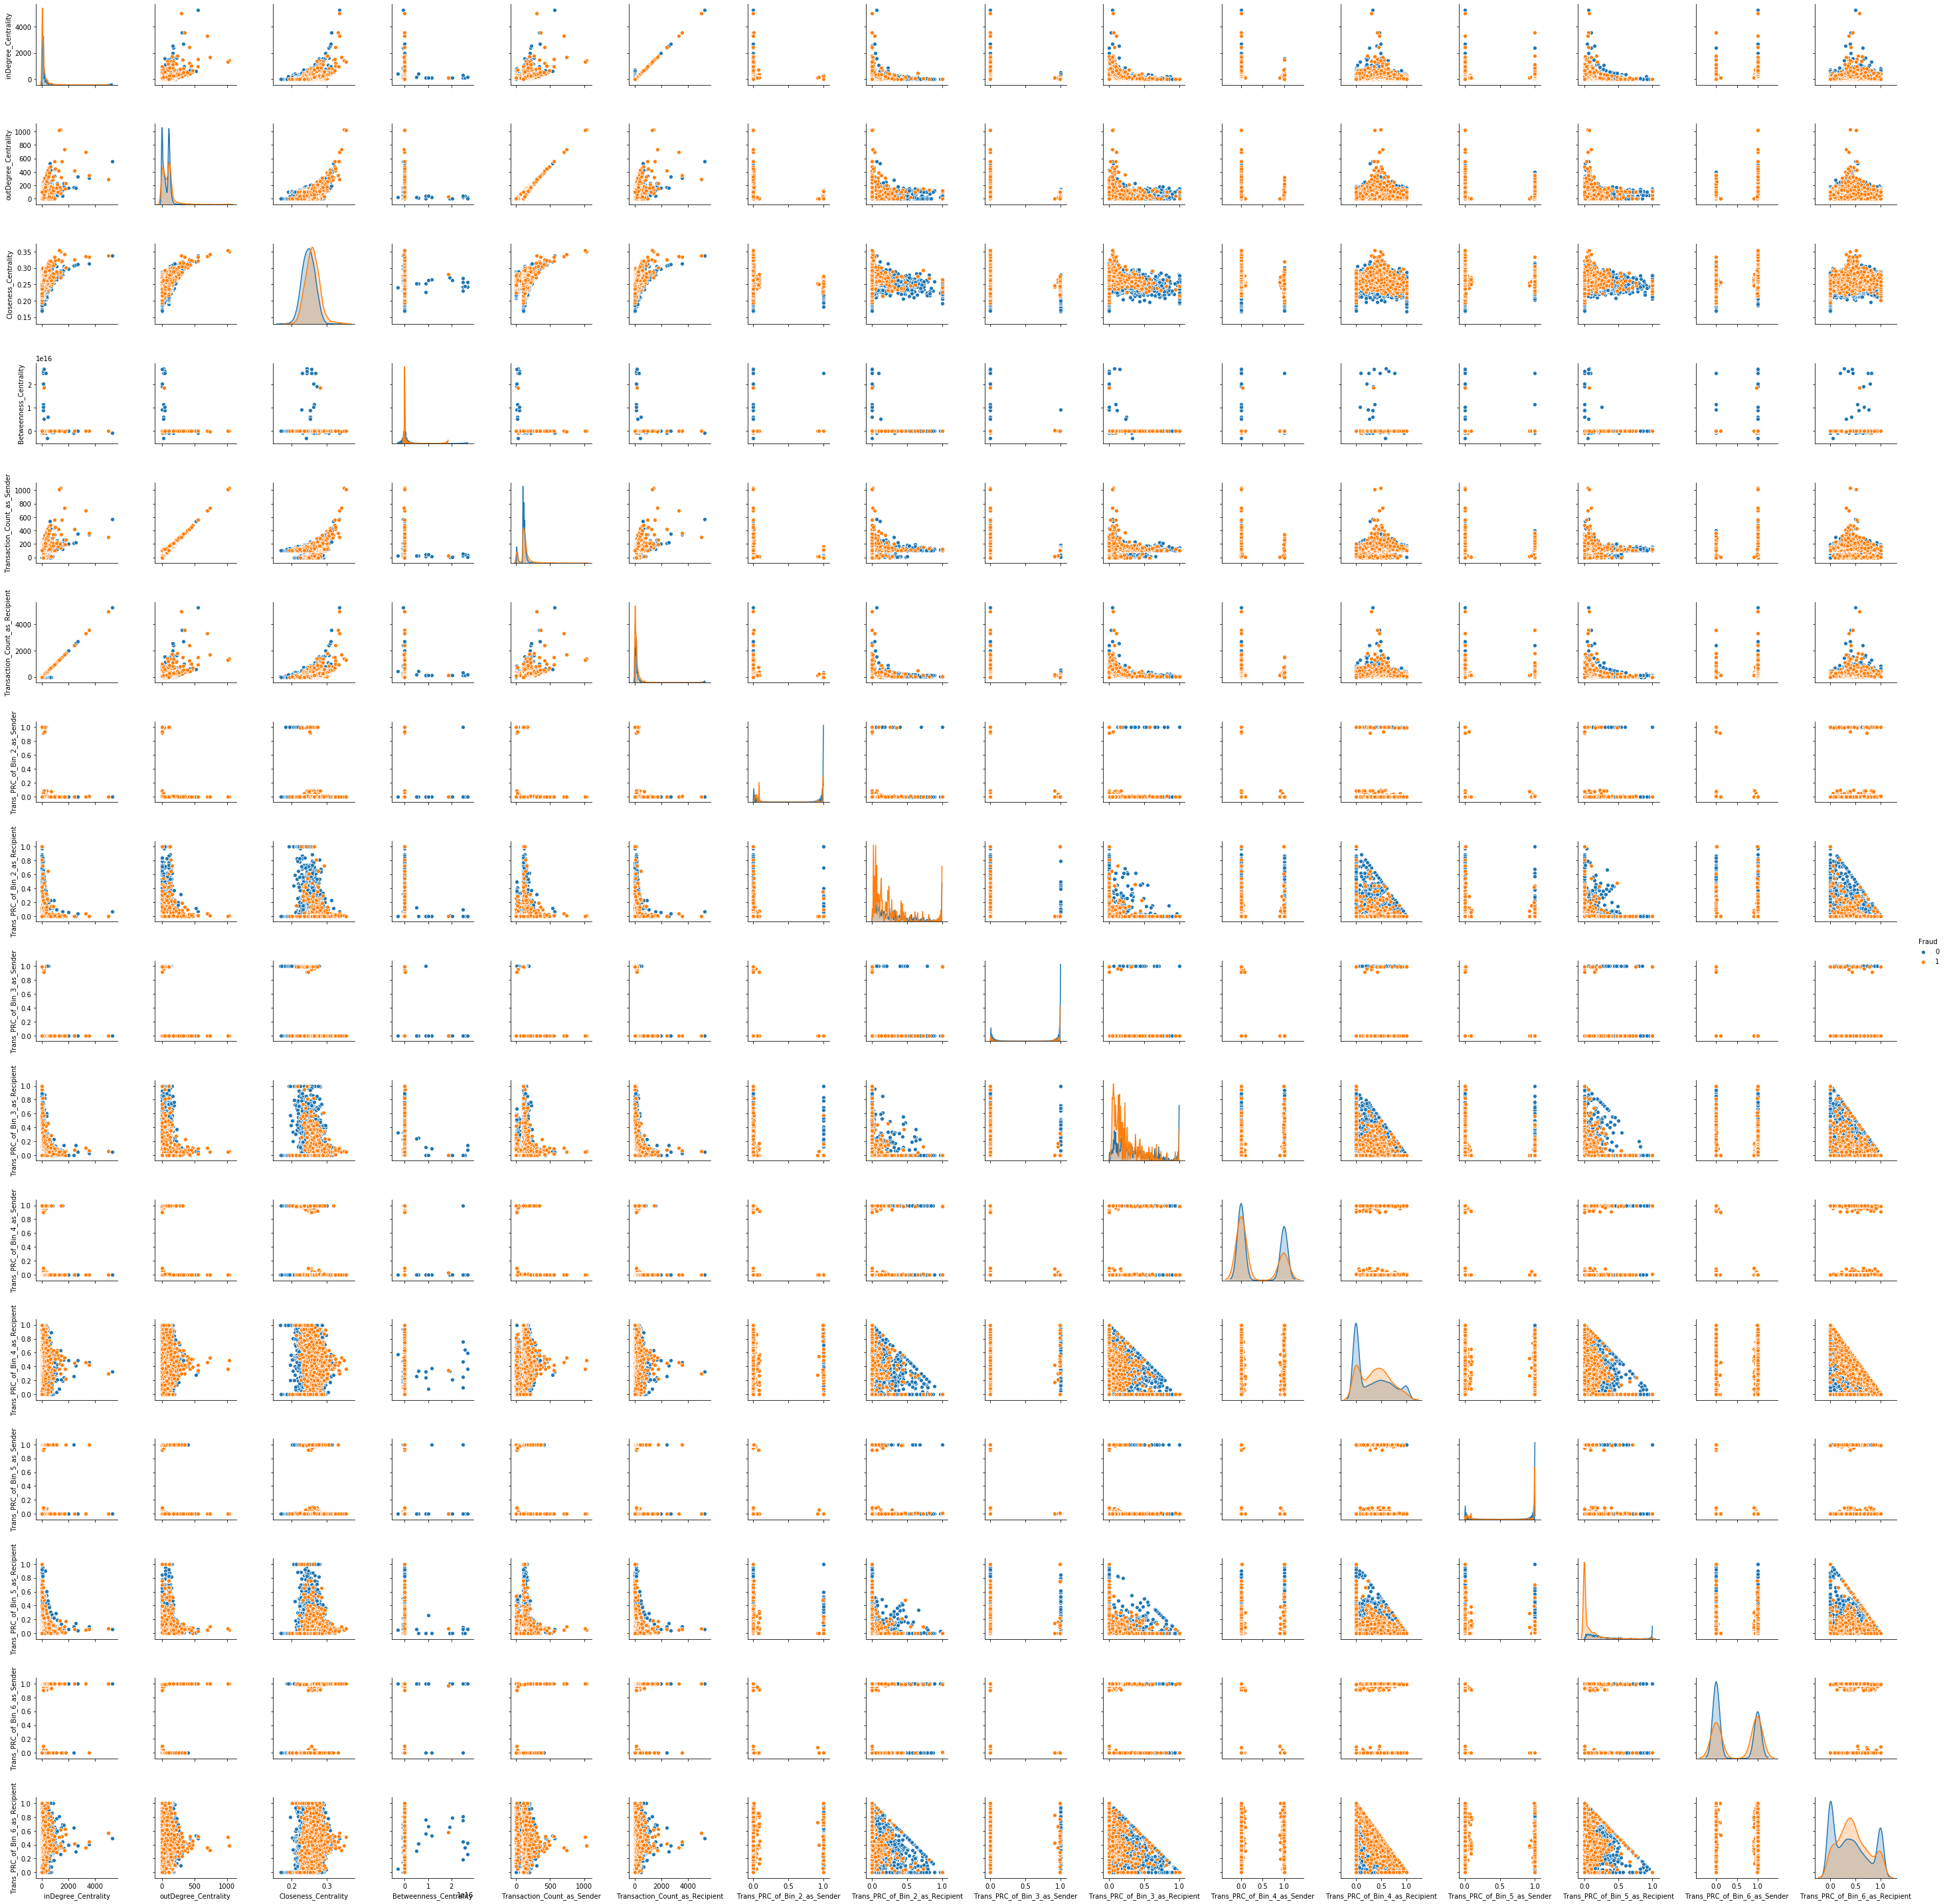

In [24]:
_ = sns.pairplot(data=labeled_accounts_df, vars=list(labeled_accounts_df.columns[3:]), hue='Fraud')

## Import Embeddings Files (created separately) and Preprocessing

In [25]:
labeled_accounts_df['Account'] = labeled_accounts_df['Account'].astype(int)

### Node2Vec

In [26]:
# 50 dims
embeddings_df_50 = pd.read_csv('n2v_10K_50.embeddings', sep=' ', encoding='utf-8', skiprows=1, header=None)
embeddings_df_50 = embeddings_df_50.rename(columns={0: "Account"})
embeddings_np_50 = embeddings_df_50.iloc[:,1:].values
embeddings_df_50['Embeddings'] = embeddings_np_50.tolist()
embeddings_df_50 = embeddings_df_50[['Account','Embeddings']]
n2v_df_50 = pd.merge(embeddings_df_50, labeled_accounts_df, how='inner', on = 'Account')

# 100 dims
embeddings_df_100 = pd.read_csv('n2v_10K_100.embeddings', sep=' ', encoding='utf-8', skiprows=1, header=None)
embeddings_df_100 = embeddings_df_100.rename(columns={0: "Account"})
embeddings_np_100 = embeddings_df_100.iloc[:,1:].values
embeddings_df_100['Embeddings'] = embeddings_np_100.tolist()
embeddings_df_100 = embeddings_df_100[['Account','Embeddings']]
n2v_df_100 = pd.merge(embeddings_df_100, labeled_accounts_df, how='inner', on = 'Account')

# 200 dims
embeddings_df_200 = pd.read_csv('n2v_10K_200.embeddings', sep=' ', encoding='utf-8', skiprows=1, header=None)
embeddings_df_200 = embeddings_df_200.rename(columns={0: "Account"})
embeddings_np_200 = embeddings_df_200.iloc[:,1:].values
embeddings_df_200['Embeddings'] = embeddings_np_200.tolist()
embeddings_df_200 = embeddings_df_200[['Account','Embeddings']]
n2v_df_200 = pd.merge(embeddings_df_200, labeled_accounts_df, how='inner', on = 'Account')

### PyTorch BigGraph

In [27]:
# 50 dims
embeddings_df_50 = pd.read_csv('pbg_10K_50.embeddings', sep='\t', encoding='utf-8', nrows=len(labeled_accounts_df), header=None)
embeddings_df_50 = embeddings_df_50.rename(columns={0: "Account"})
embeddings_np_50 = embeddings_df_50.iloc[:,1:].values
embeddings_df_50['Embeddings'] = embeddings_np_50.tolist()
embeddings_df_50 = embeddings_df_50[['Account','Embeddings']]
pbg_df_50 = pd.merge(embeddings_df_50, labeled_accounts_df, how='inner', on = 'Account')

# 100 dims
embeddings_df_100 = pd.read_csv('pbg_10K_100.embeddings', sep='\t', encoding='utf-8', nrows=len(labeled_accounts_df), header=None)
embeddings_df_100 = embeddings_df_100.rename(columns={0: "Account"})
embeddings_np_100 = embeddings_df_100.iloc[:,1:].values
embeddings_df_100['Embeddings'] = embeddings_np_100.tolist()
embeddings_df_100 = embeddings_df_100[['Account','Embeddings']]
pbg_df_100 = pd.merge(embeddings_df_100, labeled_accounts_df, how='inner', on = 'Account')

# 200 dims
embeddings_df_200 = pd.read_csv('pbg_10K_200.embeddings', sep='\t', encoding='utf-8', nrows=len(labeled_accounts_df), header=None)
embeddings_df_200 = embeddings_df_200.rename(columns={0: "Account"})
embeddings_np_200 = embeddings_df_200.iloc[:,1:].values
embeddings_df_200['Embeddings'] = embeddings_np_200.tolist()
embeddings_df_200 = embeddings_df_200[['Account','Embeddings']]
pbg_df_200 = pd.merge(embeddings_df_200, labeled_accounts_df, how='inner', on = 'Account')

## Part 1 - Predictive Modeling

### 1. Logistic Regression

#### Feature Selection Without Embeddings, Without Standardization

In [28]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

The best results are for using 5 features

AUC Score:
0.679

Confusion Matrix:
[[2985    3]
 [ 305    7]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient']



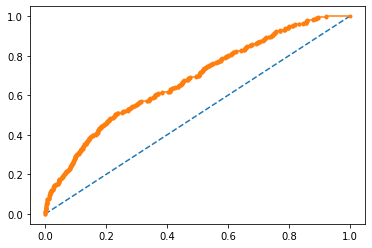

In [29]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='liblinear', max_iter=500, C=10)
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection Without Embeddings, With Standardization

In [30]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 14 features

AUC Score:
0.701

Confusion Matrix:
[[2982    6]
 [ 304    8]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



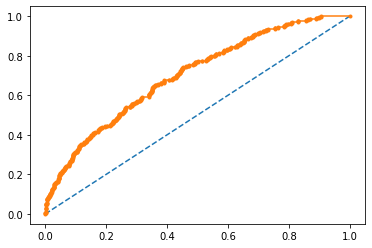

In [31]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='liblinear', max_iter=500, C=10)
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))      
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, With Standardization)

In [32]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [33]:
tuned_parameters = [{'solver': ['liblinear', 'saga', 'lbfgs'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}]}]

clf = GridSearchCV(LogisticRegression(max_iter=5000), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'C': 1000, 'class_weight': {1: 5}, 'solver': 'saga'}

Grid scores on development set:

0.693 (+/-0.013) for {'C': 0.001, 'class_weight': {1: 2}, 'solver': 'liblinear'}
0.690 (+/-0.014) for {'C': 0.001, 'class_weight': {1: 2}, 'solver': 'saga'}
0.690 (+/-0.014) for {'C': 0.001, 'class_weight': {1: 2}, 'solver': 'lbfgs'}
0.695 (+/-0.012) for {'C': 0.001, 'class_weight': {1: 3}, 'solver': 'liblinear'}
0.693 (+/-0.013) for {'C': 0.001, 'class_weight': {1: 3}, 'solver': 'saga'}
0.693 (+/-0.013) for {'C': 0.001, 'class_weight': {1: 3}, 'solver': 'lbfgs'}
0.696 (+/-0.011) for {'C': 0.001, 'class_weight': {1: 4}, 'solver': 'liblinear'}
0.695 (+/-0.012) for {'C': 0.001, 'class_weight': {1: 4}, 'solver': 'saga'}
0.695 (+/-0.012) for {'C': 0.001, 'class_weight': {1: 4}, 'solver': 'lbfgs'}
0.697 (+/-0.011) for {'C': 0.001, 'class_weight': {1: 5}, 'solver': 'liblinear'}
0.696 (+/-0.011) for {'C': 0.001, 'class_weight': {1: 5}, 'solver': 'saga'}
0.696 

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, With Standardization) - Excluding highly correlated variables

In [34]:
X = labeled_accounts_df.loc[:, ['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [35]:
tuned_parameters = [{'solver': ['liblinear', 'saga', 'lbfgs'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}]}]

clf = GridSearchCV(LogisticRegression(max_iter=5000), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'C': 1, 'class_weight': {1: 5}, 'solver': 'liblinear'}

Grid scores on development set:

0.695 (+/-0.010) for {'C': 0.001, 'class_weight': {1: 2}, 'solver': 'liblinear'}
0.693 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 2}, 'solver': 'saga'}
0.693 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 2}, 'solver': 'lbfgs'}
0.695 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 3}, 'solver': 'liblinear'}
0.694 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 3}, 'solver': 'saga'}
0.694 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 3}, 'solver': 'lbfgs'}
0.695 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 4}, 'solver': 'liblinear'}
0.695 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 4}, 'solver': 'saga'}
0.695 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 4}, 'solver': 'lbfgs'}
0.696 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 5}, 'solver': 'liblinear'}
0.695 (+/-0.009) for {'C': 0.001, 'class_weight': {1: 5}, 'solver': 'saga'}
0.69

#### Final Score Without Embeddings

Confusion Matrix:
[[2554  434]
 [ 192  120]]

AUC Score:
0.703



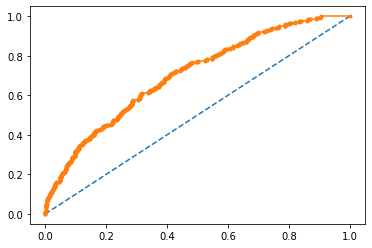

In [36]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
clf_lgr.fit(X_train, y_train)
predictions_lgr = clf_lgr.predict(X_test)
prob_predictions = clf_lgr.predict_proba(X_test)
fraud_predictions = prob_predictions[:, 1]
auc = roc_auc_score(y_test, fraud_predictions)
fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
    
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_lgr))
print()
print('AUC Score:')
print('%.3f' % auc)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 50dim Embeddings, Without Standardization

In [37]:
X = np.array(n2v_df_50['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_50.loc[:, 'inDegree_Centrality':]))
y = n2v_df_50['Fraud'].to_numpy()

The best results are for using 1 features

AUC Score:
0.659

Confusion Matrix:
[[2656  313]
 [ 255   76]]

Best Features:
['Closeness_Centrality']



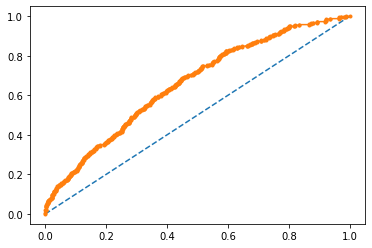

In [38]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(n2v_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 50dim Embeddings, With Standardization

In [39]:
X = np.array(n2v_df_50['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_50.loc[:, 'inDegree_Centrality':]))
y = n2v_df_50['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 5 features

AUC Score:
0.696

Confusion Matrix:
[[2575  394]
 [ 222  109]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient']



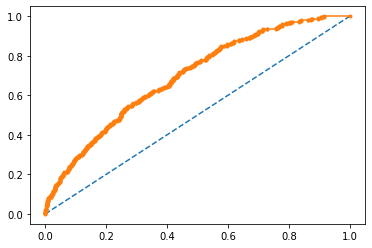

In [40]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(n2v_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 100dim Embeddings, Without Standardization

In [41]:
X = np.array(n2v_df_100['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_100.loc[:, 'inDegree_Centrality':]))
y = n2v_df_100['Fraud'].to_numpy()

The best results are for using 1 features

AUC Score:
0.659

Confusion Matrix:
[[2137  853]
 [ 153  157]]

Best Features:
['Closeness_Centrality']



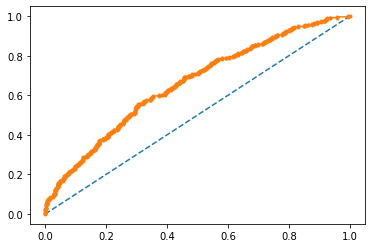

In [42]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(n2v_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 100dim Embeddings, With Standardization

In [43]:
X = np.array(n2v_df_100['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_100.loc[:, 'inDegree_Centrality':]))
y = n2v_df_100['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 10 features

AUC Score:
0.709

Confusion Matrix:
[[2539  451]
 [ 193  117]]

Best Features:
['Embedding_19', 'Embedding_23', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



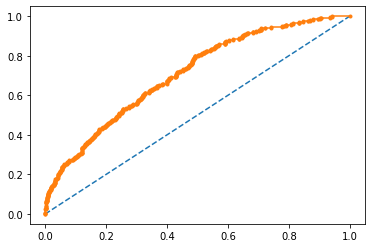

In [44]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(n2v_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 200dim Embeddings, Without Standardization

In [45]:
X = np.array(n2v_df_200['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_200.loc[:, 'inDegree_Centrality':]))
y = n2v_df_200['Fraud'].to_numpy()

The best results are for using 1 features

AUC Score:
0.668

Confusion Matrix:
[[2715  270]
 [ 246   69]]

Best Features:
['Closeness_Centrality']



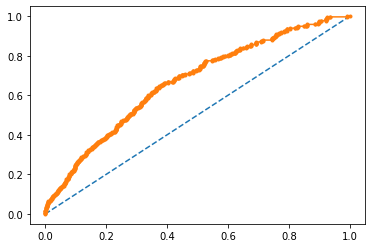

In [46]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(n2v_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 200dim Embeddings, With Standardization

In [47]:
X = np.array(n2v_df_200['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_200.loc[:, 'inDegree_Centrality':]))
y = n2v_df_200['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 5 features

AUC Score:
0.699

Confusion Matrix:
[[2557  428]
 [ 206  109]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient']



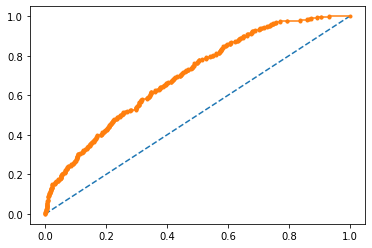

In [48]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(n2v_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, Without Standardization

In [49]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'inDegree_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()

The best results are for using 1 features

AUC Score:
0.660

Confusion Matrix:
[[2671  293]
 [ 256   80]]

Best Features:
['Closeness_Centrality']



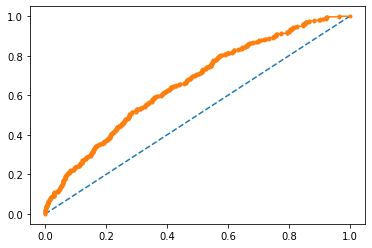

In [50]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, With Standardization

In [51]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'inDegree_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 30 features

AUC Score:
0.709

Confusion Matrix:
[[2600  364]
 [ 230  106]]

Best Features:
['Embedding_3', 'Embedding_4', 'Embedding_7', 'Embedding_8', 'Embedding_12', 'Embedding_17', 'Embedding_21', 'Embedding_24', 'Embedding_25', 'Embedding_26', 'Embedding_29', 'Embedding_33', 'Embedding_34', 'Embedding_38', 'Embedding_44', 'Embedding_46', 'Embedding_47', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



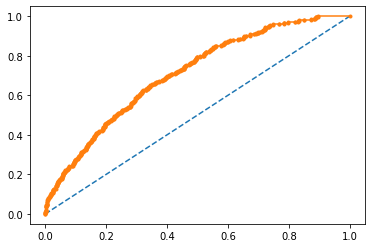

In [52]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 100dim Embeddings, Without Standardization

In [53]:
X = np.array(pbg_df_100['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_100.loc[:, 'inDegree_Centrality':]))
y = pbg_df_100['Fraud'].to_numpy()

The best results are for using 1 features

AUC Score:
0.645

Confusion Matrix:
[[2636  323]
 [ 261   80]]

Best Features:
['Closeness_Centrality']



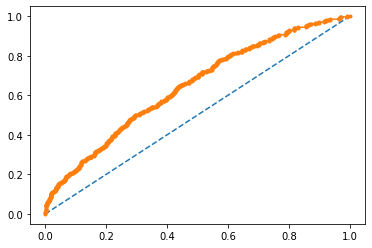

In [54]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(pbg_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 100dim Embeddings, With Standardization

In [55]:
X = np.array(pbg_df_100['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_100.loc[:, 'inDegree_Centrality':]))
y = pbg_df_100['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 44 features

AUC Score:
0.706

Confusion Matrix:
[[2555  404]
 [ 233  108]]

Best Features:
['Embedding_9', 'Embedding_10', 'Embedding_11', 'Embedding_13', 'Embedding_14', 'Embedding_17', 'Embedding_19', 'Embedding_21', 'Embedding_23', 'Embedding_25', 'Embedding_33', 'Embedding_34', 'Embedding_41', 'Embedding_42', 'Embedding_45', 'Embedding_50', 'Embedding_52', 'Embedding_54', 'Embedding_56', 'Embedding_57', 'Embedding_58', 'Embedding_60', 'Embedding_61', 'Embedding_64', 'Embedding_65', 'Embedding_66', 'Embedding_77', 'Embedding_84', 'Embedding_89', 'Embedding_91', 'Embedding_96', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_B

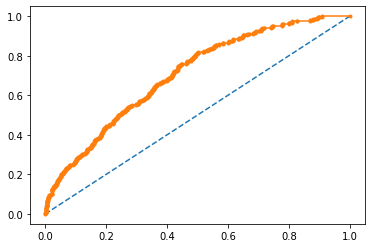

In [56]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(pbg_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 200dim Embeddings, Without Standardization

In [57]:
X = np.array(pbg_df_200['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_200.loc[:, 'inDegree_Centrality':]))
y = pbg_df_200['Fraud'].to_numpy()

The best results are for using 1 features

AUC Score:
0.661

Confusion Matrix:
[[2777  198]
 [ 271   54]]

Best Features:
['Closeness_Centrality']



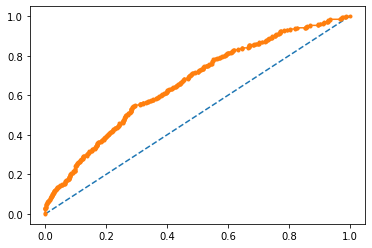

In [58]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(pbg_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 200dim Embeddings, With Standardization

In [59]:
X = np.array(pbg_df_200['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_200.loc[:, 'inDegree_Centrality':]))
y = pbg_df_200['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 27 features

AUC Score:
0.712

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      2975
           1       0.22      0.38      0.28       325

    accuracy                           0.81      3300
   macro avg       0.57      0.62      0.58      3300
weighted avg       0.86      0.81      0.83      3300


Confusion Matrix:
[[2536  439]
 [ 200  125]]

Best Features:
['Embedding_15', 'Embedding_24', 'Embedding_45', 'Embedding_92', 'Embedding_99', 'Embedding_112', 'Embedding_123', 'Embedding_132', 'Embedding_144', 'Embedding_147', 'Embedding_149', 'Embedding_153', 'Embedding_154', 'Embedding_163', 'Embedding_188', 'Embedding_189', 'Embedding_196', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans

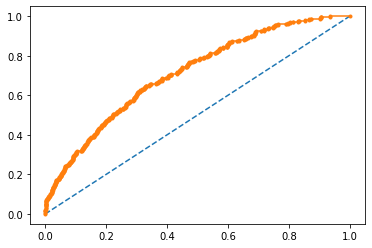

In [60]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(pbg_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_lgr = LogisticRegression(solver='saga', max_iter=5000, C=1000, class_weight={1: 5})
    clf_lgr.fit(X_train, y_train)
    prob_predictions = clf_lgr.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        best_model = clf_lgr
        predictions_lgr = clf_lgr.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_lgr)
        best_classification_report = classification_report(y_test, predictions_lgr)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Classification Report:')
print(best_classification_report)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [61]:
best_model.intercept_

array([-0.87952789])

In [62]:
tmp_df = pd.DataFrame({'Feature':best_features,'Coefficient':best_model.coef_[0]})
tmp_df.reindex(tmp_df.Coefficient.abs().sort_values(ascending=False).index)

,Feature,Coefficient
17,inDegree_Centrality,-1.535092
21,Transaction_Count_as_Recipient,1.512709
19,Closeness_Centrality,0.854690
18,outDegree_Centrality,-0.730524
20,Transaction_Count_as_Sender,0.676756
4,Embedding_99,0.127540
10,Embedding_149,-0.095245
9,Embedding_147,0.091904
7,Embedding_132,-0.080671
2,Embedding_45,-0.071244


<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">This is the highest score for the Logistic Regression. Many of the 200 dim PyTorch BigGraph embeddings proved helpful for our model by achieving the highest AUC of 0.712.</font></p>

### 2. SVM

#### Feature Selection Without Embeddings, Without Standardization

In [63]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

The best results are for using 5 features

AUC Score:
0.731

Confusion Matrix:
[[2987    1]
 [ 296   16]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient']



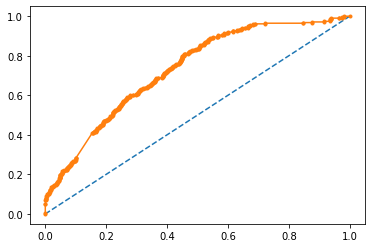

In [64]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='auto', probability=True)
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))  
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection Without Embeddings, With Standardization

In [65]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 8 features

AUC Score:
0.880

Confusion Matrix:
[[2987    1]
 [ 307    5]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



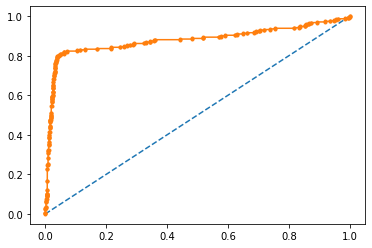

In [66]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='auto', probability=True)
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support())) 
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, With Standardization)

In [67]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [68]:
tuned_parameters = [{'C': [1, 10, 100, 1000], 'gamma': ['auto', 'scale'], 'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}]}]

clf = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'C': 100, 'class_weight': {1: 2}, 'gamma': 'auto'}

Grid scores on development set:

0.826 (+/-0.035) for {'C': 1, 'class_weight': {1: 2}, 'gamma': 'auto'}
0.827 (+/-0.036) for {'C': 1, 'class_weight': {1: 2}, 'gamma': 'scale'}
0.788 (+/-0.028) for {'C': 1, 'class_weight': {1: 3}, 'gamma': 'auto'}
0.788 (+/-0.029) for {'C': 1, 'class_weight': {1: 3}, 'gamma': 'scale'}
0.773 (+/-0.019) for {'C': 1, 'class_weight': {1: 4}, 'gamma': 'auto'}
0.773 (+/-0.017) for {'C': 1, 'class_weight': {1: 4}, 'gamma': 'scale'}
0.763 (+/-0.020) for {'C': 1, 'class_weight': {1: 5}, 'gamma': 'auto'}
0.764 (+/-0.020) for {'C': 1, 'class_weight': {1: 5}, 'gamma': 'scale'}
0.867 (+/-0.040) for {'C': 10, 'class_weight': {1: 2}, 'gamma': 'auto'}
0.866 (+/-0.039) for {'C': 10, 'class_weight': {1: 2}, 'gamma': 'scale'}
0.851 (+/-0.039) for {'C': 10, 'class_weight': {1: 3}, 'gamma': 'auto'}
0.851 (+/-0.038) for {'C': 10, 'class_weight': {1: 3}, 'gamma': 'scale'}
0.841

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, With Standardization) - Excluding highly correlated variables

In [69]:
X = labeled_accounts_df.loc[:, ['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [70]:
tuned_parameters = [{'C': [1, 10, 100, 1000], 'gamma': ['auto', 'scale'], 'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}]}]

clf = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'C': 100, 'class_weight': {1: 3}, 'gamma': 'scale'}

Grid scores on development set:

0.863 (+/-0.032) for {'C': 1, 'class_weight': {1: 2}, 'gamma': 'auto'}
0.863 (+/-0.031) for {'C': 1, 'class_weight': {1: 2}, 'gamma': 'scale'}
0.838 (+/-0.022) for {'C': 1, 'class_weight': {1: 3}, 'gamma': 'auto'}
0.839 (+/-0.023) for {'C': 1, 'class_weight': {1: 3}, 'gamma': 'scale'}
0.811 (+/-0.025) for {'C': 1, 'class_weight': {1: 4}, 'gamma': 'auto'}
0.812 (+/-0.025) for {'C': 1, 'class_weight': {1: 4}, 'gamma': 'scale'}
0.789 (+/-0.022) for {'C': 1, 'class_weight': {1: 5}, 'gamma': 'auto'}
0.788 (+/-0.022) for {'C': 1, 'class_weight': {1: 5}, 'gamma': 'scale'}
0.882 (+/-0.036) for {'C': 10, 'class_weight': {1: 2}, 'gamma': 'auto'}
0.882 (+/-0.036) for {'C': 10, 'class_weight': {1: 2}, 'gamma': 'scale'}
0.875 (+/-0.042) for {'C': 10, 'class_weight': {1: 3}, 'gamma': 'auto'}
0.874 (+/-0.043) for {'C': 10, 'class_weight': {1: 3}, 'gamma': 'scale'}
0.86

#### Final Score Without Embeddings

AUC Score:
0.898

Confusion Matrix:
[[2961   27]
 [  75  237]]



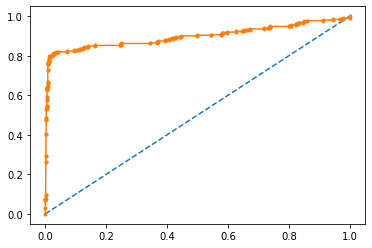

In [71]:
X = labeled_accounts_df.loc[:, ['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
clf_svm.fit(X_train, y_train)
prob_predictions = clf_svm.predict_proba(X_test)
fraud_predictions = prob_predictions[:, 1]
auc = roc_auc_score(y_test, fraud_predictions)
predictions_svm = clf_svm.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)

print('AUC Score:')
print('%.3f' % auc)
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_svm))
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 50dim Embeddings, With Standardization

In [72]:
X = np.array(n2v_df_50['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_50.loc[:, 'Closeness_Centrality':]))
y = n2v_df_50['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 5 features

AUC Score:
0.875

Confusion Matrix:
[[2950   19]
 [  93  238]]

Best Features:
['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



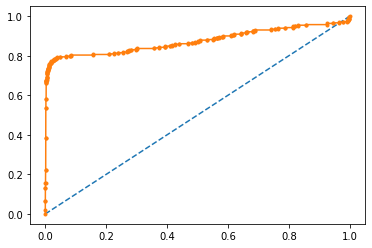

In [73]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(n2v_df_50.loc[:, 'Closeness_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 100dim Embeddings, With Standardization

In [74]:
X = np.array(n2v_df_100['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_100.loc[:, 'Closeness_Centrality':]))
y = n2v_df_100['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 5 features

AUC Score:
0.865

Confusion Matrix:
[[2963   27]
 [  84  226]]

Best Features:
['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



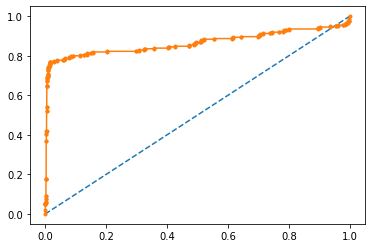

In [75]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(n2v_df_100.loc[:, 'Closeness_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 200dim Embeddings, With Standardization

In [76]:
X = np.array(n2v_df_200['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_200.loc[:, 'Closeness_Centrality':]))
y = n2v_df_200['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 5 features

AUC Score:
0.884

Confusion Matrix:
[[2951   34]
 [  85  230]]

Best Features:
['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



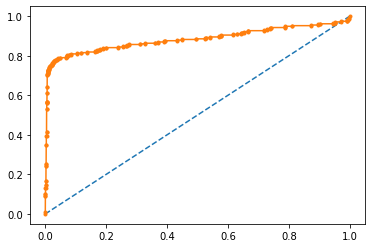

In [77]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(n2v_df_200.loc[:, 'Closeness_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, With Standardization

In [78]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'Closeness_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 7 features

AUC Score:
0.915

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2962
           1       0.89      0.68      0.77       338

    accuracy                           0.96      3300
   macro avg       0.93      0.83      0.87      3300
weighted avg       0.96      0.96      0.96      3300


Confusion Matrix:
[[2933   29]
 [ 109  229]]

Best Features:
['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



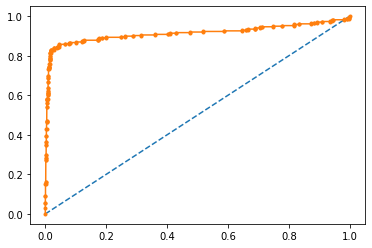

In [79]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'Closeness_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_classification_report = classification_report(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Classification Report:')
print(best_classification_report)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 100dim Embeddings, With Standardization

In [80]:
X = np.array(pbg_df_100['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_100.loc[:, 'Closeness_Centrality':]))
y = pbg_df_100['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 7 features

AUC Score:
0.890

Confusion Matrix:
[[2927   32]
 [ 129  212]]

Best Features:
['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



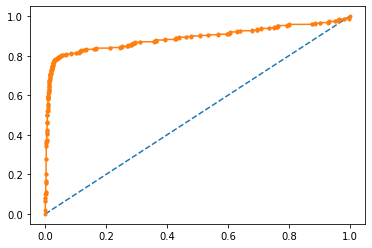

In [81]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(pbg_df_100.loc[:, 'Closeness_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 200dim Embeddings, With Standardization

In [82]:
X = np.array(pbg_df_200['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_200.loc[:, 'Closeness_Centrality':]))
y = pbg_df_200['Fraud'].to_numpy()
X = StandardScaler().fit_transform(X)

The best results are for using 7 features

AUC Score:
0.867

Confusion Matrix:
[[2939   36]
 [ 110  215]]

Best Features:
['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



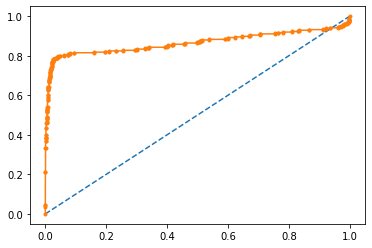

In [83]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(pbg_df_200.loc[:, 'Closeness_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_svm = SVC(gamma='scale', probability=True, C=100, class_weight={1: 3})
    clf_svm.fit(X_train, y_train)
    prob_predictions = clf_svm.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_svm = clf_svm.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_svm)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The best results for SVM, are achieved without node embeddings.</font></p>

### 3. Random Forest

#### Feature Selection Without Embeddings, Without Standardization

In [84]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

The best results are for using 14 features

AUC Score:
0.954

Confusion Matrix:
[[2988    0]
 [ 238   74]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



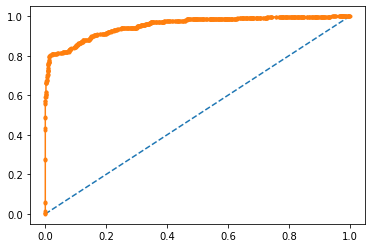

In [85]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection Without Embeddings, With Standardization

In [86]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 14 features

AUC Score:
0.954

Confusion Matrix:
[[2988    0]
 [ 238   74]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



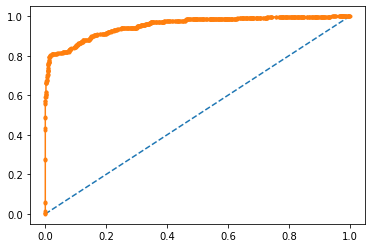

In [87]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, Without Standardization)

In [88]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [89]:
tuned_parameters = [{'n_estimators': [10, 100, 1000], 'max_depth': [2, 3, 4, 5], 'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}]}]

clf = GridSearchCV(RandomForestClassifier(random_state=0), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'class_weight': {1: 2}, 'max_depth': 5, 'n_estimators': 1000}

Grid scores on development set:

0.916 (+/-0.016) for {'class_weight': {1: 2}, 'max_depth': 2, 'n_estimators': 10}
0.925 (+/-0.015) for {'class_weight': {1: 2}, 'max_depth': 2, 'n_estimators': 100}
0.928 (+/-0.013) for {'class_weight': {1: 2}, 'max_depth': 2, 'n_estimators': 1000}
0.934 (+/-0.014) for {'class_weight': {1: 2}, 'max_depth': 3, 'n_estimators': 10}
0.947 (+/-0.015) for {'class_weight': {1: 2}, 'max_depth': 3, 'n_estimators': 100}
0.948 (+/-0.014) for {'class_weight': {1: 2}, 'max_depth': 3, 'n_estimators': 1000}
0.952 (+/-0.012) for {'class_weight': {1: 2}, 'max_depth': 4, 'n_estimators': 10}
0.960 (+/-0.007) for {'class_weight': {1: 2}, 'max_depth': 4, 'n_estimators': 100}
0.959 (+/-0.009) for {'class_weight': {1: 2}, 'max_depth': 4, 'n_estimators': 1000}
0.949 (+/-0.016) for {'class_weight': {1: 2}, 'max_depth': 5, 'n_estimators': 10}
0.962 (+/-0.007) for {'clas

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, Without Standardization) - Excluding highly correlated variables

In [90]:
X = labeled_accounts_df.loc[:, ['Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [91]:
tuned_parameters = [{'n_estimators': [10, 100, 1000], 'max_depth': [2, 3, 4, 5], 'class_weight': [{1: 2}, {1: 3}, {1: 4}, {1: 5}]}]

clf = GridSearchCV(RandomForestClassifier(random_state=0), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'class_weight': {1: 4}, 'max_depth': 5, 'n_estimators': 1000}

Grid scores on development set:

0.928 (+/-0.014) for {'class_weight': {1: 2}, 'max_depth': 2, 'n_estimators': 10}
0.925 (+/-0.009) for {'class_weight': {1: 2}, 'max_depth': 2, 'n_estimators': 100}
0.927 (+/-0.012) for {'class_weight': {1: 2}, 'max_depth': 2, 'n_estimators': 1000}
0.926 (+/-0.013) for {'class_weight': {1: 2}, 'max_depth': 3, 'n_estimators': 10}
0.946 (+/-0.011) for {'class_weight': {1: 2}, 'max_depth': 3, 'n_estimators': 100}
0.945 (+/-0.015) for {'class_weight': {1: 2}, 'max_depth': 3, 'n_estimators': 1000}
0.942 (+/-0.011) for {'class_weight': {1: 2}, 'max_depth': 4, 'n_estimators': 10}
0.953 (+/-0.009) for {'class_weight': {1: 2}, 'max_depth': 4, 'n_estimators': 100}
0.956 (+/-0.011) for {'class_weight': {1: 2}, 'max_depth': 4, 'n_estimators': 1000}
0.951 (+/-0.007) for {'class_weight': {1: 2}, 'max_depth': 5, 'n_estimators': 10}
0.958 (+/-0.007) for {'clas

#### Final Score Without Embeddings

Confusion Matrix:
[[2988    0]
 [  72  240]]

AUC Score:
0.960



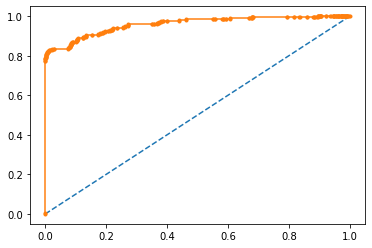

In [92]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
clf_rnf.fit(X_train, y_train)
predictions_rnf = clf_rnf.predict(X_test)
prob_predictions = clf_rnf.predict_proba(X_test)
fraud_predictions = prob_predictions[:, 1]
auc = roc_auc_score(y_test, fraud_predictions)
fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
    
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_rnf))
print()
print('AUC Score:')
print('%.3f' % auc)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 50dim Embeddings, Without Standardization

In [93]:
X = np.array(n2v_df_50['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_50.loc[:, 'inDegree_Centrality':]))
y = n2v_df_50['Fraud'].to_numpy()

The best results are for using 8 features

AUC Score:
0.964

Confusion Matrix:
[[2965    4]
 [  93  238]]

Best Features:
['Embedding_29', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



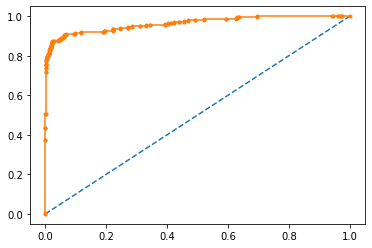

In [94]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(n2v_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 50dim Embeddings, With Standardization

In [95]:
X = np.array(n2v_df_50['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_50.loc[:, 'inDegree_Centrality':]))
y = n2v_df_50['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 8 features

AUC Score:
0.964

Confusion Matrix:
[[2965    4]
 [  93  238]]

Best Features:
['Embedding_29', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



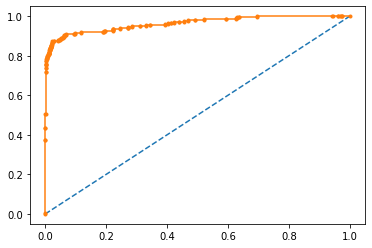

In [96]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(n2v_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">As expected, the Random Forest Classifier is not affected by standardization of features. The following tests will not use standardization.</font></p>

#### Feature Selection With Node2Vec 100dim Embeddings, Without Standardization

In [97]:
X = np.array(n2v_df_100['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_100.loc[:, 'inDegree_Centrality':]))
y = n2v_df_100['Fraud'].to_numpy()

The best results are for using 7 features

AUC Score:
0.968

Confusion Matrix:
[[2988    2]
 [  72  238]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



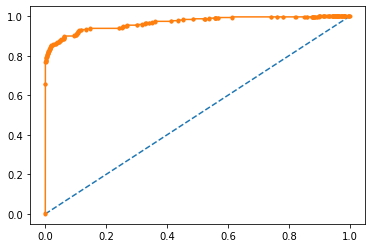

In [98]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(n2v_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 200dim Embeddings, Without Standardization

In [99]:
X = np.array(n2v_df_200['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_200.loc[:, 'inDegree_Centrality':]))
y = n2v_df_200['Fraud'].to_numpy()

The best results are for using 8 features

AUC Score:
0.958

Confusion Matrix:
[[2981    4]
 [  91  224]]

Best Features:
['Embedding_29', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



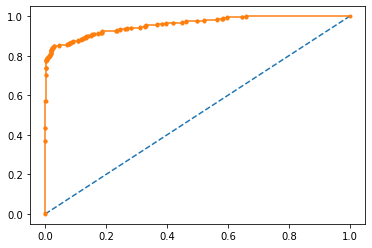

In [100]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(n2v_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, Without Standardization

In [101]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'inDegree_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()

The best results are for using 15 features

AUC Score:
0.972

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2962
           1       1.00      0.66      0.80       338

    accuracy                           0.97      3300
   macro avg       0.98      0.83      0.89      3300
weighted avg       0.97      0.97      0.96      3300


Confusion Matrix:
[[2962    0]
 [ 114  224]]

Best Features:
['Embedding_4', 'Embedding_35', 'Embedding_39', 'Embedding_50', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



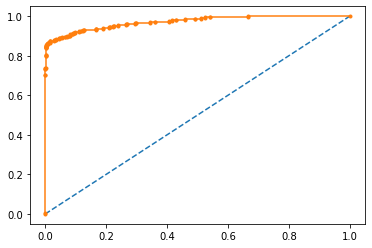

In [102]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        best_model = clf_rnf
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_classification_report = classification_report(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_feature_importances = clf_rnf.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Classification Report:')
print(best_classification_report)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [103]:
tmp_dict = {'Feature': best_features, 'Importance': best_feature_importances}
pd.DataFrame(tmp_dict).sort_values('Importance',ascending=False)

,Feature,Importance
13,Trans_PRC_of_Bin_6_as_Sender,0.272740
12,Trans_PRC_of_Bin_5_as_Sender,0.210914
10,Trans_PRC_of_Bin_4_as_Sender,0.172617
7,Transaction_Count_as_Sender,0.112866
5,outDegree_Centrality,0.066791
6,Closeness_Centrality,0.047921
8,Transaction_Count_as_Recipient,0.033845
4,inDegree_Centrality,0.017589
14,Trans_PRC_of_Bin_6_as_Recipient,0.017209
11,Trans_PRC_of_Bin_4_as_Recipient,0.015164


#### Feature Selection With PyTorch BigGraph 100dim Embeddings, Without Standardization

In [104]:
X = np.array(pbg_df_100['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_100.loc[:, 'inDegree_Centrality':]))
y = pbg_df_100['Fraud'].to_numpy()

The best results are for using 12 features

AUC Score:
0.958

Confusion Matrix:
[[2959    0]
 [ 105  236]]

Best Features:
['Embedding_13', 'Embedding_64', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



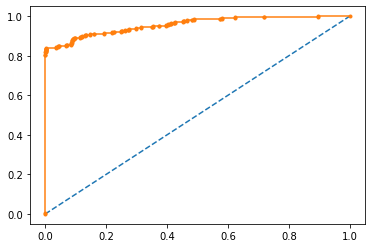

In [105]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(pbg_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 200dim Embeddings, Without Standardization

In [106]:
X = np.array(pbg_df_200['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_200.loc[:, 'inDegree_Centrality':]))
y = pbg_df_200['Fraud'].to_numpy()

The best results are for using 19 features

AUC Score:
0.965

Confusion Matrix:
[[2975    0]
 [ 105  220]]

Best Features:
['Embedding_45', 'Embedding_99', 'Embedding_112', 'Embedding_132', 'Embedding_144', 'Embedding_147', 'Embedding_149', 'Embedding_154', 'Embedding_188', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



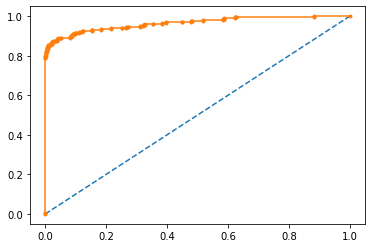

In [107]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(pbg_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_rnf = RandomForestClassifier(n_estimators=1000, max_depth=5, class_weight={1: 2}, random_state=0)
    clf_rnf.fit(X_train, y_train)
    prob_predictions = clf_rnf.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_rnf = clf_rnf.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_rnf)
        best_num_of_features = feat_num
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The Random Forest Classifier seems to benefit from using node embeddings. The best results come from using the 50dim PyTorch BigGraph embeddings.</font></p>

### 4. AdaBoost

#### Feature Selection Without Embeddings, Without Standardization

In [108]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

The best results are for using 14 features

AUC Score:
0.975

Confusion Matrix:
[[2988    0]
 [  52  260]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



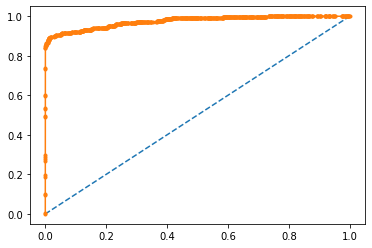

In [109]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection Without Embeddings, With Standardization

In [110]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X = StandardScaler().fit_transform(X)

The best results are for using 14 features

AUC Score:
0.975

Confusion Matrix:
[[2988    0]
 [  52  260]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



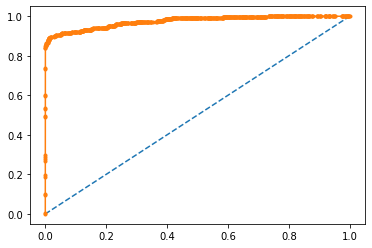

In [111]:
num_of_features = list(range(np.shape(X)[1]+1))
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=100, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), k_best.get_support()))  
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Hyperparameter Tuning Using the Best Features (Without Embeddings, Without Standardization)

In [112]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [113]:
tuned_parameters = [{'n_estimators': [10, 100, 1000], 'learning_rate': [0.001, 0.01, 0.1, 1]}]

clf = GridSearchCV(AdaBoostClassifier(random_state=0), tuned_parameters, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

Best parameters set found on development set:

{'learning_rate': 0.1, 'n_estimators': 1000}

Grid scores on development set:

0.649 (+/-0.020) for {'learning_rate': 0.001, 'n_estimators': 10}
0.759 (+/-0.123) for {'learning_rate': 0.001, 'n_estimators': 100}
0.832 (+/-0.014) for {'learning_rate': 0.001, 'n_estimators': 1000}
0.759 (+/-0.123) for {'learning_rate': 0.01, 'n_estimators': 10}
0.832 (+/-0.014) for {'learning_rate': 0.01, 'n_estimators': 100}
0.946 (+/-0.015) for {'learning_rate': 0.01, 'n_estimators': 1000}
0.790 (+/-0.026) for {'learning_rate': 0.1, 'n_estimators': 10}
0.948 (+/-0.018) for {'learning_rate': 0.1, 'n_estimators': 100}
0.977 (+/-0.009) for {'learning_rate': 0.1, 'n_estimators': 1000}
0.951 (+/-0.011) for {'learning_rate': 1, 'n_estimators': 10}
0.975 (+/-0.008) for {'learning_rate': 1, 'n_estimators': 100}
0.973 (+/-0.008) for {'learning_rate': 1, 'n_estimators': 1000}

Detailed classification report:

The model is trained on the full development set.
The sco

#### Final Score Without Embeddings

Confusion Matrix:
[[2988    0]
 [  54  258]]

AUC Score:
0.975



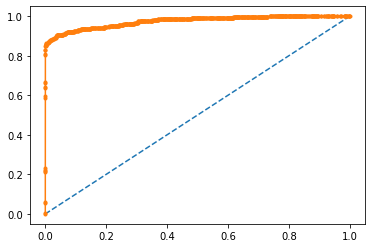

In [114]:
X = labeled_accounts_df.loc[:, ['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
clf_abst.fit(X_train, y_train)
predictions_abst = clf_abst.predict(X_test)
prob_predictions = clf_abst.predict_proba(X_test)
fraud_predictions = prob_predictions[:, 1]
auc = roc_auc_score(y_test, fraud_predictions)
fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
    
print('Confusion Matrix:')
print(confusion_matrix(y_test, predictions_abst))
print()
print('AUC Score:')
print('%.3f' % auc)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 50dim Embeddings, Without Standardization

In [115]:
X = np.array(n2v_df_50['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_50.loc[:, 'inDegree_Centrality':]))
y = n2v_df_50['Fraud'].to_numpy()

The best results are for using 27 features

AUC Score:
0.976

Confusion Matrix:
[[2969    0]
 [  52  279]]

Best Features:
['Embedding_4', 'Embedding_5', 'Embedding_13', 'Embedding_16', 'Embedding_17', 'Embedding_19', 'Embedding_23', 'Embedding_29', 'Embedding_31', 'Embedding_32', 'Embedding_37', 'Embedding_38', 'Embedding_43', 'Embedding_44', 'Embedding_47', 'Embedding_48', 'Embedding_49', 'Embedding_50', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



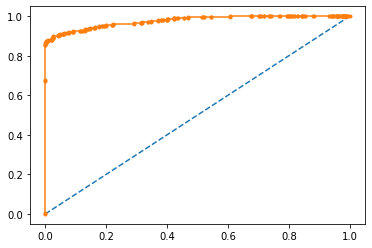

In [116]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(n2v_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 100dim Embeddings, Without Standardization

In [117]:
X = np.array(n2v_df_100['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_100.loc[:, 'inDegree_Centrality':]))
y = n2v_df_100['Fraud'].to_numpy()

The best results are for using 10 features

AUC Score:
0.977

Confusion Matrix:
[[2989    1]
 [  52  258]]

Best Features:
['Embedding_19', 'Embedding_23', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



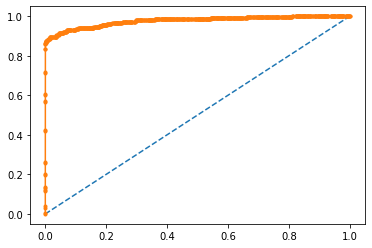

In [118]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(n2v_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With Node2Vec 200dim Embeddings, Without Standardization

In [119]:
X = np.array(n2v_df_200['Embeddings'].values.tolist())
X = np.hstack((X, n2v_df_200.loc[:, 'inDegree_Centrality':]))
y = n2v_df_200['Fraud'].to_numpy()

The best results are for using 132 features

AUC Score:
0.974

Confusion Matrix:
[[2985    0]
 [  55  260]]

Best Features:
['Embedding_2', 'Embedding_3', 'Embedding_4', 'Embedding_5', 'Embedding_6', 'Embedding_7', 'Embedding_8', 'Embedding_10', 'Embedding_11', 'Embedding_13', 'Embedding_17', 'Embedding_18', 'Embedding_19', 'Embedding_21', 'Embedding_23', 'Embedding_24', 'Embedding_25', 'Embedding_29', 'Embedding_30', 'Embedding_32', 'Embedding_33', 'Embedding_34', 'Embedding_35', 'Embedding_37', 'Embedding_40', 'Embedding_42', 'Embedding_43', 'Embedding_44', 'Embedding_47', 'Embedding_52', 'Embedding_54', 'Embedding_55', 'Embedding_56', 'Embedding_58', 'Embedding_60', 'Embedding_64', 'Embedding_65', 'Embedding_66', 'Embedding_69', 'Embedding_70', 'Embedding_71', 'Embedding_72', 'Embedding_75', 'Embedding_76', 'Embedding_78', 'Embedding_79', 'Embedding_80', 'Embedding_81', 'Embedding_82', 'Embedding_85', 'Embedding_87', 'Embedding_88', 'Embedding_91', 'Embedding_92', 'Embedding_93', 'E

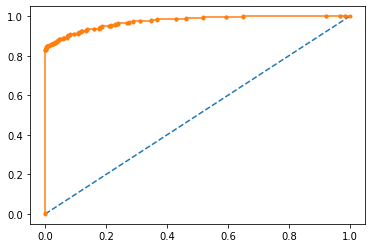

In [120]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(n2v_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, Without Standardization

In [121]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'inDegree_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()

The best results are for using 21 features

AUC Score:
0.980

Confusion Matrix:
[[2962    0]
 [  48  290]]

Best Features:
['Embedding_4', 'Embedding_9', 'Embedding_17', 'Embedding_21', 'Embedding_24', 'Embedding_29', 'Embedding_35', 'Embedding_39', 'Embedding_50', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



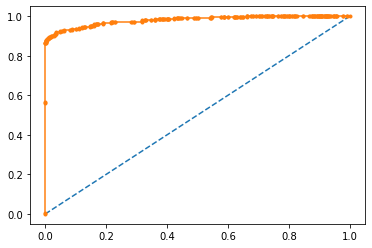

In [122]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support())) 
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [123]:
tmp_dict = {'Feature': best_features, 'Importance': best_feature_importances}
pd.DataFrame(tmp_dict).sort_values('Importance',ascending=False)

,Feature,Importance
12,Transaction_Count_as_Sender,0.204
19,Trans_PRC_of_Bin_6_as_Sender,0.179
10,outDegree_Centrality,0.176
16,Trans_PRC_of_Bin_4_as_Sender,0.143
18,Trans_PRC_of_Bin_5_as_Sender,0.091
11,Closeness_Centrality,0.046
4,Embedding_24,0.019
5,Embedding_29,0.017
1,Embedding_9,0.017
6,Embedding_35,0.015


#### Feature Selection With PyTorch BigGraph 100dim Embeddings, Without Standardization

In [124]:
X = np.array(pbg_df_100['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_100.loc[:, 'inDegree_Centrality':]))
y = pbg_df_100['Fraud'].to_numpy()

The best results are for using 43 features

AUC Score:
0.971

Confusion Matrix:
[[2959    0]
 [  59  282]]

Best Features:
['Embedding_9', 'Embedding_10', 'Embedding_11', 'Embedding_13', 'Embedding_14', 'Embedding_17', 'Embedding_19', 'Embedding_21', 'Embedding_23', 'Embedding_25', 'Embedding_34', 'Embedding_41', 'Embedding_42', 'Embedding_45', 'Embedding_50', 'Embedding_52', 'Embedding_54', 'Embedding_56', 'Embedding_57', 'Embedding_58', 'Embedding_60', 'Embedding_61', 'Embedding_64', 'Embedding_65', 'Embedding_66', 'Embedding_77', 'Embedding_84', 'Embedding_89', 'Embedding_91', 'Embedding_96', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipien

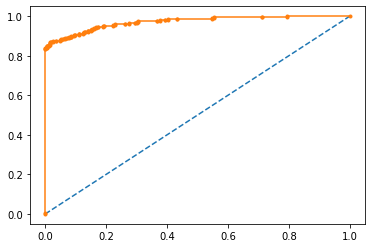

In [125]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(100)] + list(pbg_df_100.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support())) 
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 200dim Embeddings, Without Standardization

In [126]:
X = np.array(pbg_df_200['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_200.loc[:, 'inDegree_Centrality':]))
y = pbg_df_200['Fraud'].to_numpy()

The best results are for using 36 features

AUC Score:
0.976

Confusion Matrix:
[[2975    0]
 [  50  275]]

Best Features:
['Embedding_15', 'Embedding_24', 'Embedding_45', 'Embedding_53', 'Embedding_82', 'Embedding_92', 'Embedding_99', 'Embedding_112', 'Embedding_115', 'Embedding_123', 'Embedding_132', 'Embedding_144', 'Embedding_145', 'Embedding_146', 'Embedding_147', 'Embedding_149', 'Embedding_153', 'Embedding_154', 'Embedding_157', 'Embedding_161', 'Embedding_163', 'Embedding_187', 'Embedding_188', 'Embedding_189', 'Embedding_196', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



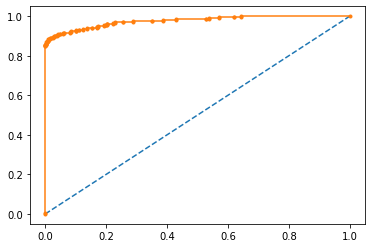

In [127]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(200)] + list(pbg_df_200.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support())) 
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Adaboost seems to benefit from using node embeddings. The best results come from using the 50dim PyTorch BigGraph embeddings.</font></p>

### 5. Further Varying Number of Epochs for the Training of PyTorch BigGraph Embeddings, used on the best performing classifier

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, Without Standardization (20 epochs training instead of 10)

In [128]:
# 50 dims // 20 epochs
embeddings_df_50 = pd.read_csv('pbg_10K_50_20e.embeddings', sep='\t', encoding='utf-8', nrows=len(labeled_accounts_df), header=None)
embeddings_df_50 = embeddings_df_50.rename(columns={0: "Account"})
embeddings_np_50 = embeddings_df_50.iloc[:,1:].values
embeddings_df_50['Embeddings'] = embeddings_np_50.tolist()
embeddings_df_50 = embeddings_df_50[['Account','Embeddings']]
pbg_df_50 = pd.merge(embeddings_df_50, labeled_accounts_df, how='inner', on = 'Account')

In [129]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'inDegree_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()

The best results are for using 22 features

AUC Score:
0.973

Confusion Matrix:
[[2975    1]
 [  54  270]]

Best Features:
['Embedding_3', 'Embedding_6', 'Embedding_10', 'Embedding_16', 'Embedding_17', 'Embedding_22', 'Embedding_30', 'Embedding_33', 'Embedding_41', 'Embedding_42', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']



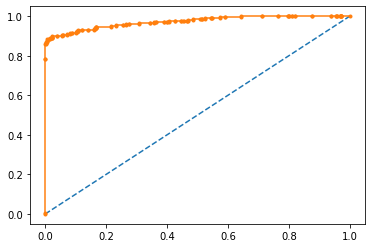

In [130]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))       
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

#### Feature Selection With PyTorch BigGraph 50dim Embeddings, Without Standardization (5 epochs training instead of 10)

In [131]:
# 50 dims // 5 epochs
embeddings_df_50 = pd.read_csv('pbg_10K_50_5e.embeddings', sep='\t', encoding='utf-8', nrows=len(labeled_accounts_df), header=None)
embeddings_df_50 = embeddings_df_50.rename(columns={0: "Account"})
embeddings_np_50 = embeddings_df_50.iloc[:,1:].values
embeddings_df_50['Embeddings'] = embeddings_np_50.tolist()
embeddings_df_50 = embeddings_df_50[['Account','Embeddings']]
pbg_df_50 = pd.merge(embeddings_df_50, labeled_accounts_df, how='inner', on = 'Account')

In [132]:
X = np.array(pbg_df_50['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_50.loc[:, 'inDegree_Centrality':]))
y = pbg_df_50['Fraud'].to_numpy()

The best results are for using 9 features

AUC Score:
0.965

Confusion Matrix:
[[2963    1]
 [  65  271]]

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_6_as_Sender']



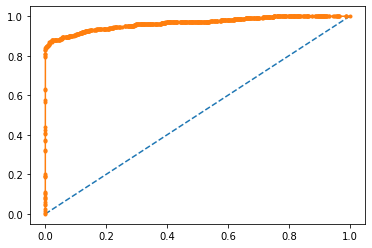

In [133]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_50.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))       
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">It seems that the training for 10 epochs scores best as far as the PyTorch BigGraph embeddings are concerned.</font></p>

### 6. Reducing Dimensions for the Training of PyTorch BigGraph Embeddings, used on the best performing classifier

#### Feature Selection With PyTorch BigGraph 20dim Embeddings, Without Standardization (10 epochs training)

In [134]:
# 20 dims // 10 epochs
embeddings_df_20 = pd.read_csv('pbg_10K_20.embeddings', sep='\t', encoding='utf-8', nrows=len(labeled_accounts_df), header=None)
embeddings_df_20 = embeddings_df_20.rename(columns={0: "Account"})
embeddings_np_20 = embeddings_df_20.iloc[:,1:].values
embeddings_df_20['Embeddings'] = embeddings_np_20.tolist()
embeddings_df_20 = embeddings_df_20[['Account','Embeddings']]
pbg_df_20 = pd.merge(embeddings_df_20, labeled_accounts_df, how='inner', on = 'Account')

In [135]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()

The best results are for using 34 features

AUC Score:
0.981

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2975
           1       1.00      0.85      0.92       325

    accuracy                           0.99      3300
   macro avg       0.99      0.93      0.96      3300
weighted avg       0.99      0.99      0.98      3300


Confusion Matrix:
[[2975    0]
 [  48  277]]

Best Features:
['Embedding_1', 'Embedding_2', 'Embedding_3', 'Embedding_4', 'Embedding_5', 'Embedding_6', 'Embedding_8', 'Embedding_9', 'Embedding_10', 'Embedding_11', 'Embedding_12', 'Embedding_14', 'Embedding_15', 'Embedding_16', 'Embedding_17', 'Embedding_18', 'Embedding_19', 'Embedding_20', 'inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Betweenness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bi

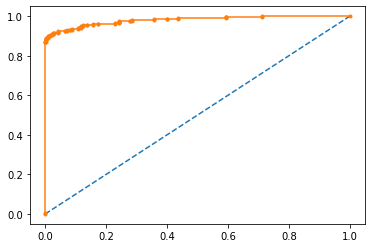

In [136]:
num_of_features = list(range(np.shape(X)[1]+1))
feature_labels = ['Embedding_' + str(x+1) for x in range(20)] + list(pbg_df_20.loc[:, 'inDegree_Centrality':].columns)
best_score = 0
for feat_num in num_of_features:
    if feat_num == 0: continue
    k_best = SelectKBest(f_classif, k=feat_num).fit(X, y)
    X_new = SelectKBest(f_classif, k=feat_num).fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)
    
    clf_abst = AdaBoostClassifier(n_estimators=1000, learning_rate=0.1, random_state=0)
    clf_abst.fit(X_train, y_train)
    prob_predictions = clf_abst.predict_proba(X_test)
    fraud_predictions = prob_predictions[:, 1]
    auc = roc_auc_score(y_test, fraud_predictions)
    if auc > best_score:
        best_score = auc
        best_model = clf_abst
        predictions_abst = clf_abst.predict(X_test)
        fpr, tpr, thresholds = roc_curve(y_test, fraud_predictions)
        best_conf_matrix = confusion_matrix(y_test, predictions_abst)
        best_classification_report = classification_report(y_test, predictions_abst)
        best_num_of_features = feat_num
        best_feature_importances = clf_abst.feature_importances_
        best_features = list(compress(feature_labels, k_best.get_support()))    
        
print('The best results are for using %s features' % best_num_of_features)
print()
print('AUC Score:')
print('%.3f' % best_score)
print()
print('Classification Report:')
print(best_classification_report)
print()
print('Confusion Matrix:')
print(best_conf_matrix)
print()
print('Best Features:')
print(best_features)
print()
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [137]:
tmp_dict = {'Feature': best_features, 'Importance': best_feature_importances}
pd.DataFrame(tmp_dict).sort_values('Importance',ascending=False)

,Feature,Importance
22,Transaction_Count_as_Sender,0.192
19,outDegree_Centrality,0.145
32,Trans_PRC_of_Bin_6_as_Sender,0.137
28,Trans_PRC_of_Bin_4_as_Sender,0.111
30,Trans_PRC_of_Bin_5_as_Sender,0.091
24,Trans_PRC_of_Bin_2_as_Sender,0.054
20,Closeness_Centrality,0.030
7,Embedding_9,0.022
8,Embedding_10,0.022
11,Embedding_14,0.019


<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">20dim embeddings scored an AUC of 0.001 better than 50dim.</font></p>

## Part 2 - Clustering

### 1.a Clustering without Node Embeddings (using PCA)

#### PCA

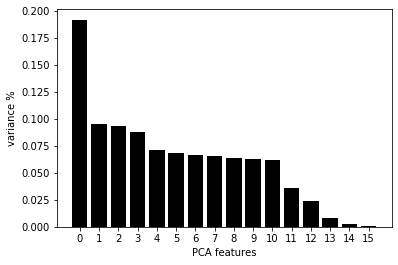

In [138]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=np.shape(X_std)[1])
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">It seems that the components 0-10 explain the majority of the variance in our data.</font></p>

#### K-means (Selecting the Number of Clusters using the Elbow Method)

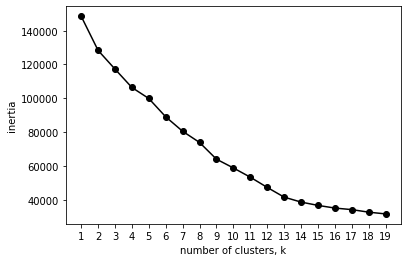

In [139]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)    
    # Select components 0-10
    model.fit(PCA_components.iloc[:,:11])   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 13 clusters.</font></p>

#### Run the K-means for 13 clusters and check if most fraud labels fall within the same cluster

In [140]:
kmeans = KMeans(n_clusters=13, random_state=0).fit(PCA_components.iloc[:,:11])
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,1,0
1,3,0
2,2,0
3,1,0
4,2,0
5,9,0
6,2,0
7,2,0
8,1,0
9,1,0


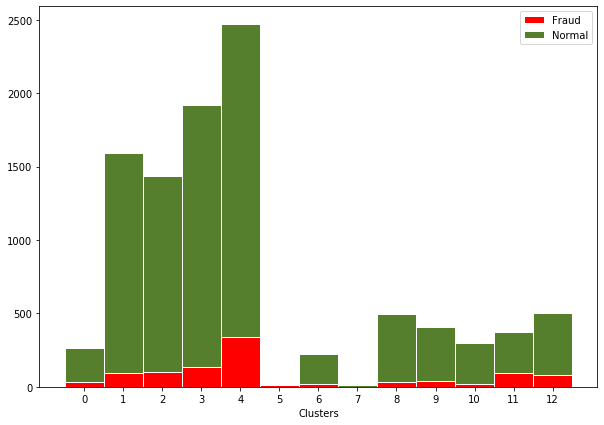

In [141]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [142]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(PCA_components.iloc[:,:11])
    score = silhouette_score(PCA_components.iloc[:,:11], preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.3581243866942495, for 13 clusters.


<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The silhouette score verifies that the elbow method's 13 clusters was the optimal choice.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [143]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(PCA_components.iloc[:,:11])
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(PCA_components.iloc[:,:11]):
        continue
    score = silhouette_score(PCA_components.iloc[:,:11], preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=9, min_samples=1, producing a silhouette_score of 0.8422528518760489


In [144]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(PCA_components.iloc[:,:11])

In [145]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


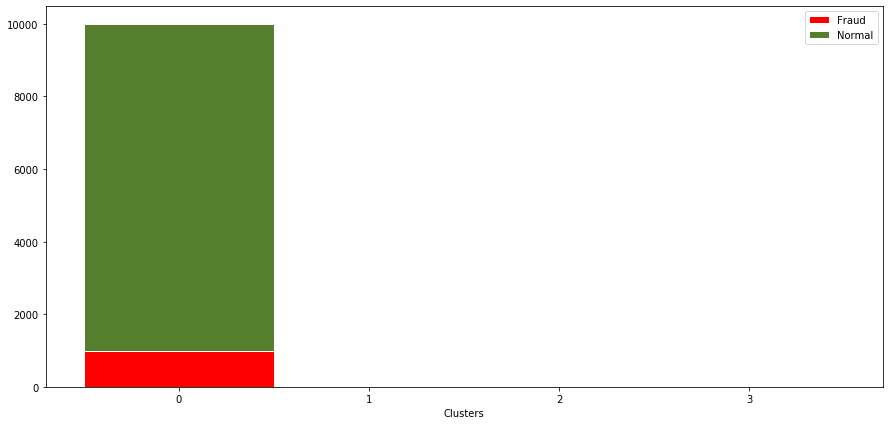

In [146]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Even though 4 clusters were formed, hyperparameter tuning using silhouette score ended up accumulating almost all accounts into a single cluster, thus explaining the high silhouette score.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [147]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(PCA_components.iloc[:,:11])
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=1, min_samples=3


In [148]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(PCA_components.iloc[:,:11])

In [149]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,0,0
9,0,0


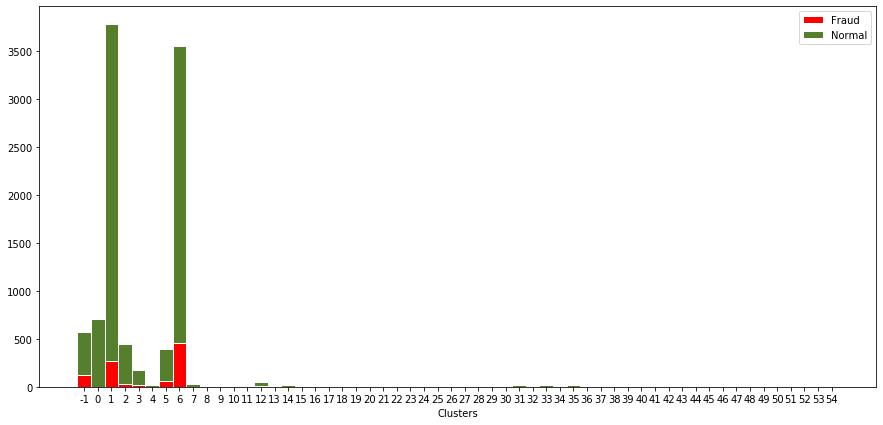

In [150]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 1.b Clustering with Node Embeddings (using PCA and 20dim PyTorch BigGraph)

#### PCA

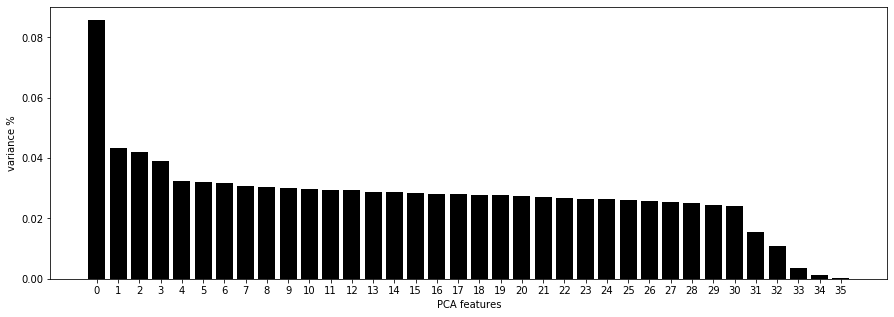

In [151]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

pca = PCA(n_components=np.shape(X_std)[1])
principalComponents = pca.fit_transform(X_std)

# Plot the explained variances
features = range(pca.n_components_)
plt.figure(figsize=(15,5))
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">It seems that the components 0-30 explain the majority of the variance in our data.</font></p>

#### K-means (Selecting the Number of Clusters using the Elbow Method)

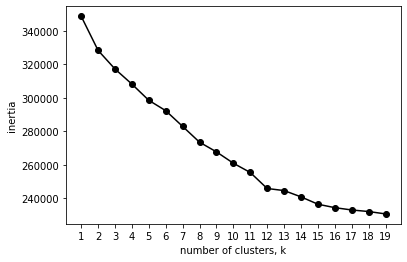

In [152]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)    
    # Select components 0-30
    model.fit(PCA_components.iloc[:,:31])   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 12 clusters.</font></p>

#### Run the K-means for 12 clusters and check if most fraud labels fall within the same cluster

In [153]:
kmeans = KMeans(n_clusters=12, random_state=0).fit(PCA_components.iloc[:,:31])
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,11,0
1,11,0
2,2,0
3,7,0
4,1,0
5,0,0
6,8,0
7,10,0
8,10,0
9,10,0


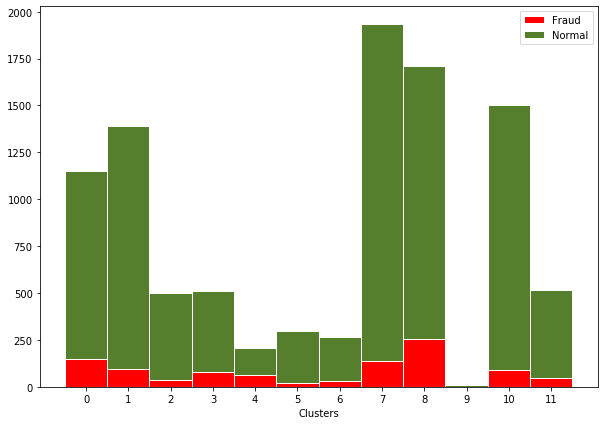

In [154]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [155]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(PCA_components.iloc[:,:31])
    score = silhouette_score(PCA_components.iloc[:,:31], preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.08113165119667412, for 6 clusters.


#### Run the K-means for 6 clusters and check if most fraud labels fall within the same cluster

In [156]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(PCA_components.iloc[:,:31])
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,2,0
1,2,0
2,1,0
3,0,0
4,0,0
5,2,0
6,2,0
7,3,0
8,3,0
9,3,0


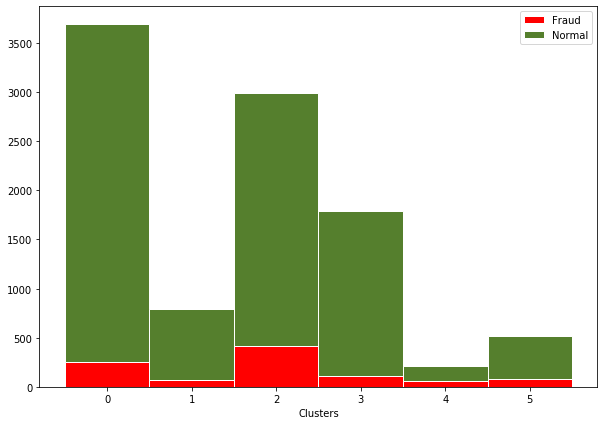

In [157]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [158]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(PCA_components.iloc[:,:31])
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(PCA_components.iloc[:,:31]):
        continue
    score = silhouette_score(PCA_components.iloc[:,:31], preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=10, min_samples=2, producing a silhouette_score of 0.6992818919012641


In [159]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(PCA_components.iloc[:,:31])

In [160]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


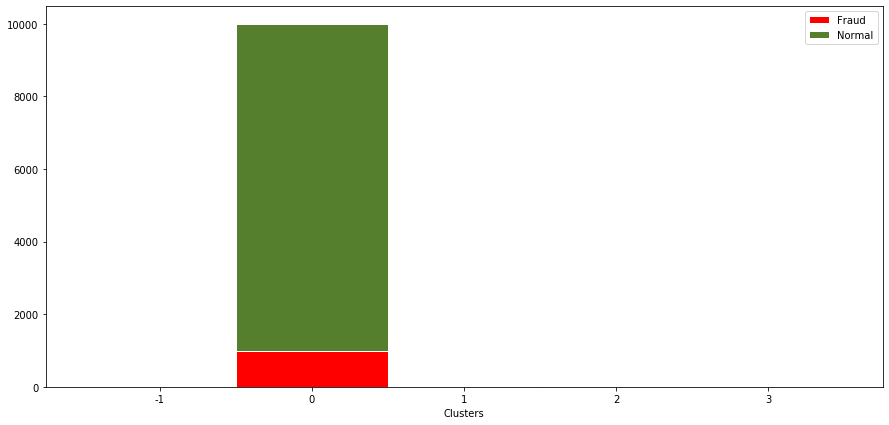

In [161]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Even though 5 clusters were formed, hyperparameter tuning using silhouette score ended up accumulating almost all accounts into a single cluster, thus explaining the high silhouette score.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [162]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(PCA_components.iloc[:,:31])
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=5, min_samples=2


In [163]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(PCA_components.iloc[:,:31])

In [164]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,-1,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


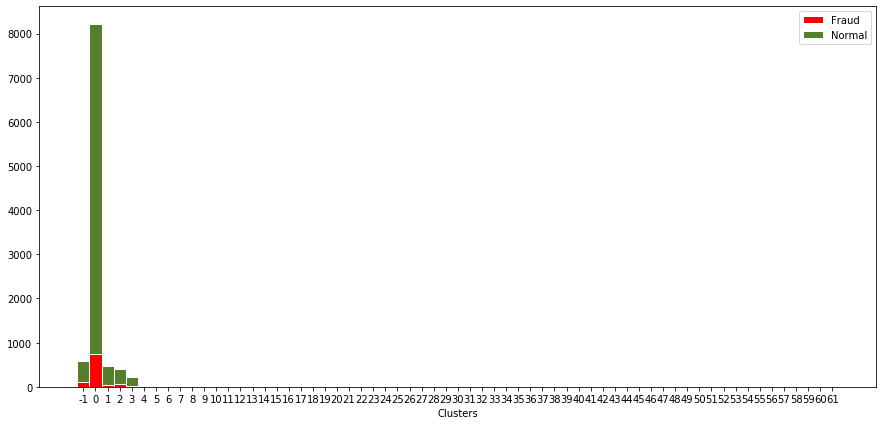

In [165]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 2.a Clustering without Node Embeddings (using All Features, Standardized)

In [166]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

#### K-means (Selecting the Number of Clusters using the Elbow Method)

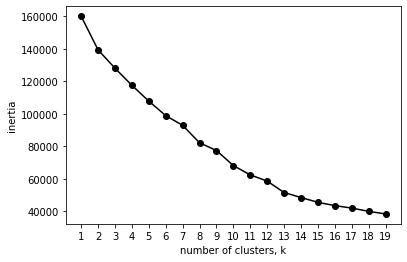

In [167]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_std)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 13 clusters.</font></p>

#### Run the K-means for 13 clusters and check if most fraud labels fall within the same cluster

In [168]:
kmeans = KMeans(n_clusters=13, random_state=0).fit(X_std)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,12,0
1,4,0
2,4,0
3,4,0
4,4,0
5,7,0
6,4,0
7,4,0
8,12,0
9,12,0


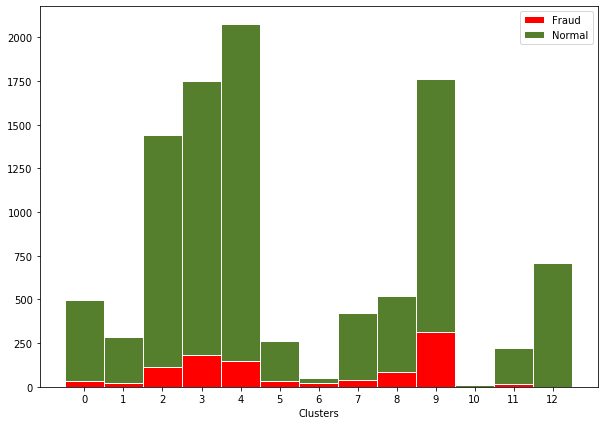

In [169]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [170]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_std)
    score = silhouette_score(X_std, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.3502041552697815, for 23 clusters.


#### Run the K-means for 23 clusters and check if most fraud labels fall within the same cluster

In [171]:
kmeans = KMeans(n_clusters=23, random_state=0).fit(X_std)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,3,0
1,16,0
2,0,0
3,20,0
4,20,0
5,19,0
6,20,0
7,20,0
8,3,0
9,3,0


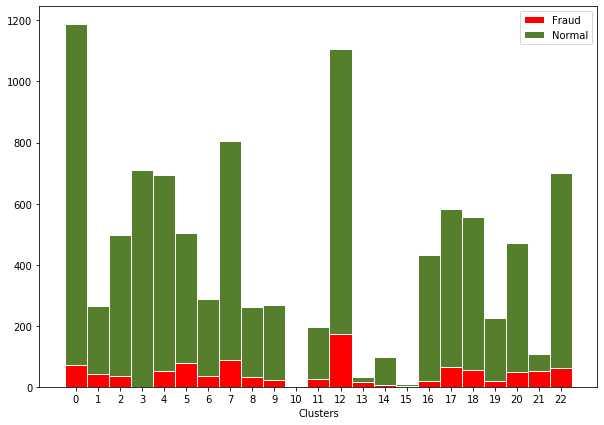

In [172]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [173]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X_std)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X_std):
        continue
    score = silhouette_score(X_std, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=9, min_samples=1, producing a silhouette_score of 0.8339562168350054


In [174]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_std)

In [175]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


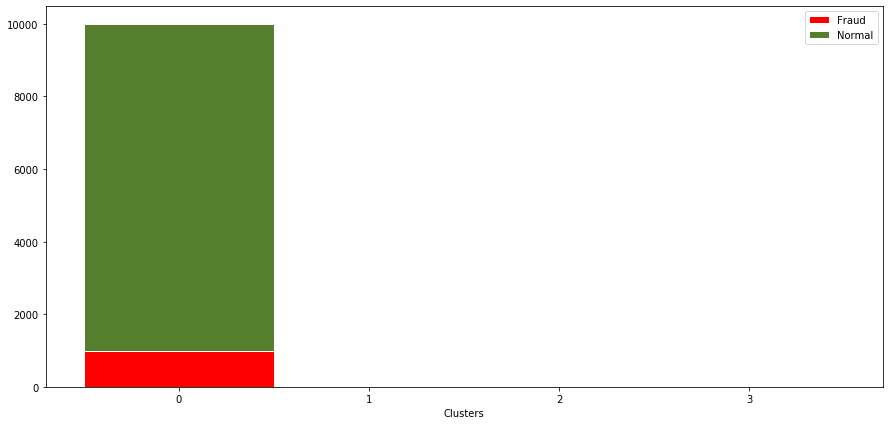

In [176]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Even though 4 clusters were formed, hyperparameter tuning using silhouette score ended up accumulating almost all accounts into a single cluster, thus explaining the high silhouette score.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [177]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X_std)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=1, min_samples=4


In [178]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_std)

In [179]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,1,0
2,4,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,0,0
9,0,0


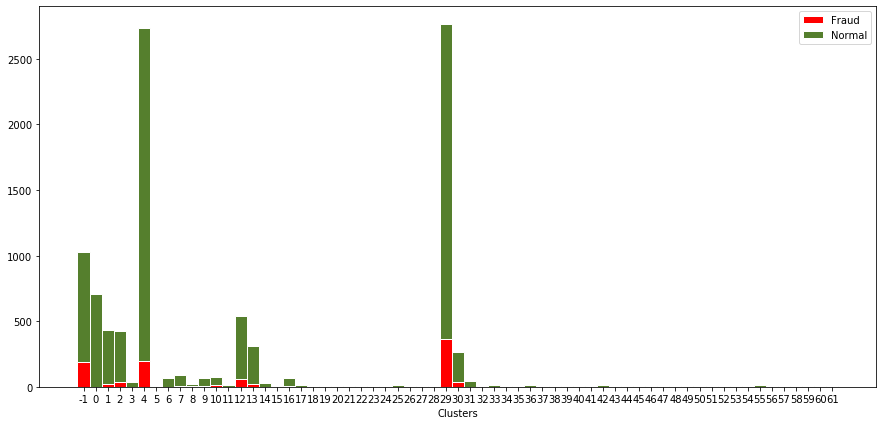

In [180]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 2.b Clustering with 20dim PyTorch BigGraph Node Embeddings (using All Features, Standardized)

In [181]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

#### K-means (Selecting the Number of Clusters using the Elbow Method)

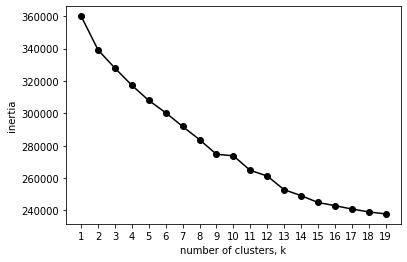

In [182]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_std)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 15 clusters.</font></p>

#### Run the K-means for 15 clusters and check if most fraud labels fall within the same cluster

In [183]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_std)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,3,0
1,12,0
2,4,0
3,7,0
4,6,0
5,1,0
6,0,0
7,5,0
8,6,0
9,5,0


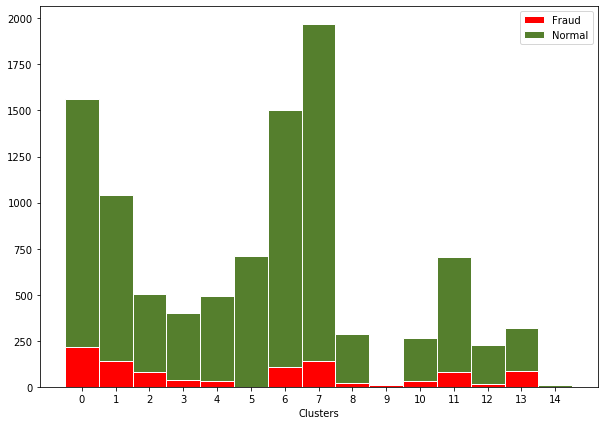

In [184]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [185]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_std)
    score = silhouette_score(X_std, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.08176933541313496, for 5 clusters.


#### Run the K-means for 5 clusters and check if most fraud labels fall within the same cluster

In [186]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_std)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,2,0
1,2,0
2,4,0
3,3,0
4,3,0
5,2,0
6,2,0
7,4,0
8,3,0
9,4,0


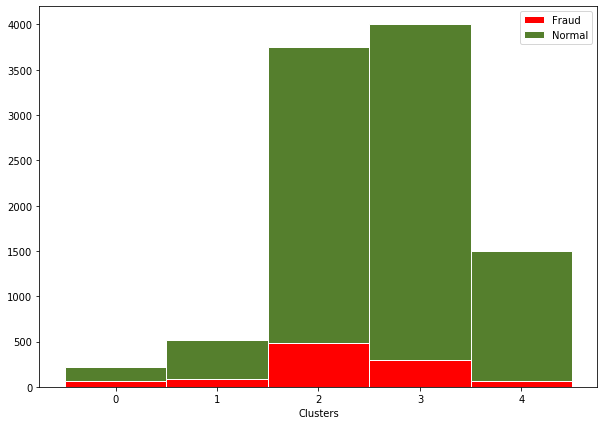

In [187]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [188]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X_std)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X_std):
        continue
    score = silhouette_score(X_std, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=10, min_samples=2, producing a silhouette_score of 0.7004596564079877


In [189]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_std)

In [190]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


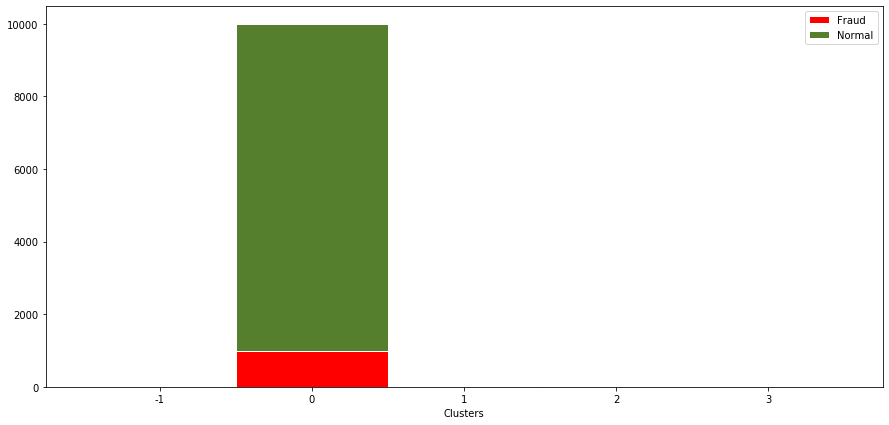

In [191]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Even though 5 clusters were formed, hyperparameter tuning using silhouette score ended up accumulating almost all accounts into a single cluster, thus explaining the high silhouette score.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [192]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X_std)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=5, min_samples=3


In [193]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_std)

In [194]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,-1,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


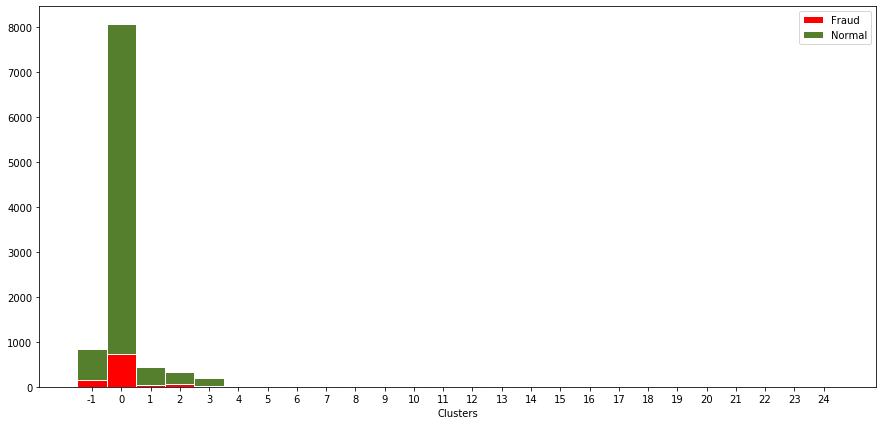

In [195]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 3.a Clustering without Node Embeddings (using All Features, Non-Standardized)

In [196]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

#### K-means (Selecting the Number of Clusters using the Elbow Method)

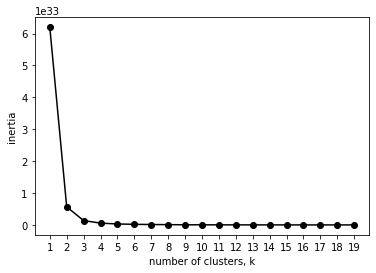

In [197]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 3 clusters.</font></p>

#### Run the K-means for 3 clusters and check if most fraud labels fall within the same cluster

In [198]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


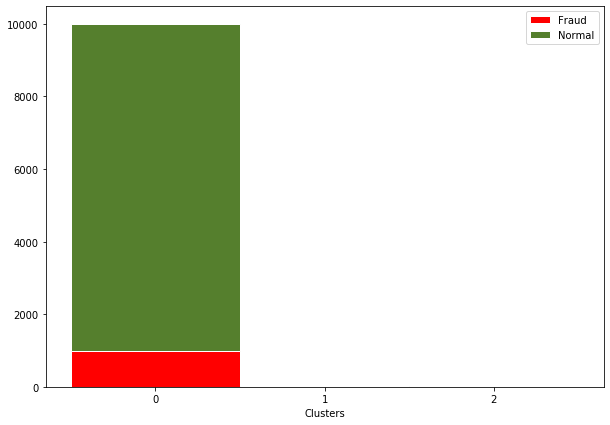

In [199]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [200]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    score = silhouette_score(X, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.9990841584486652, for 4 clusters.


#### Run the K-means for 4 clusters and check if most fraud labels fall within the same cluster

In [201]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


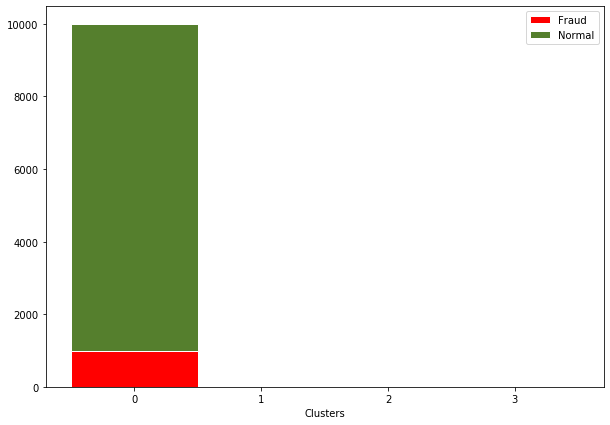

In [202]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [203]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X):
        continue
    score = silhouette_score(X, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=5, min_samples=3, producing a silhouette_score of 0


In [204]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)

In [205]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,-1,0
1,0,0
2,-1,0
3,-1,0
4,-1,0
5,-1,0
6,-1,0
7,-1,0
8,1,0
9,1,0


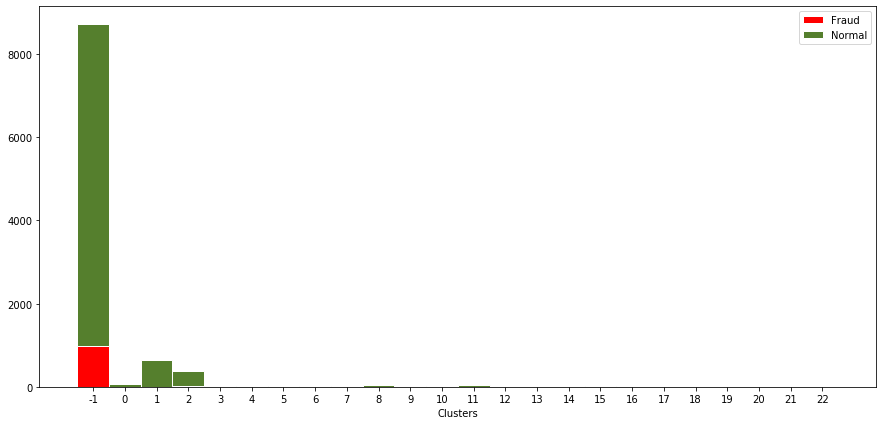

In [206]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [207]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=9, min_samples=2


In [208]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)

In [209]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,-1,0
1,0,0
2,-1,0
3,-1,0
4,-1,0
5,-1,0
6,-1,0
7,-1,0
8,1,0
9,1,0


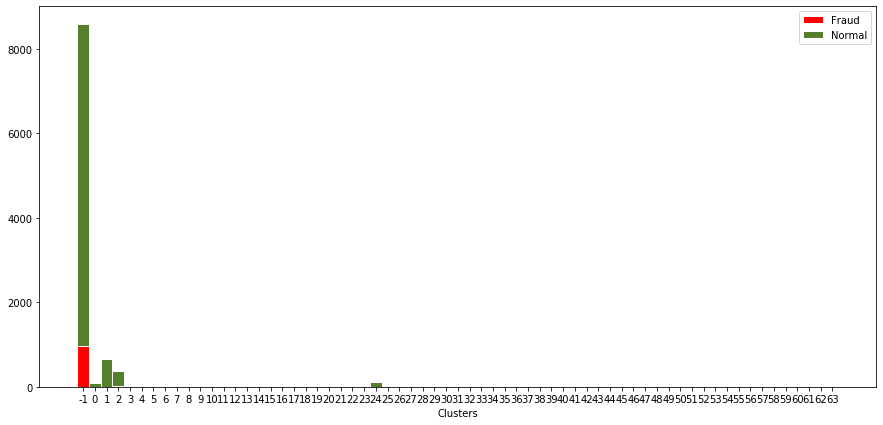

In [210]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 3.b Clustering with 20dim PyTorch BigGraph Node Embeddings (using All Features, Non-Standardized)

In [211]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()

#### K-means (Selecting the Number of Clusters using the Elbow Method)

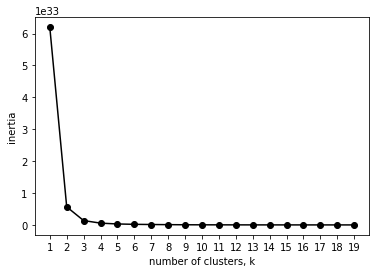

In [212]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 3 clusters.</font></p>

#### Run the K-means for 3 clusters and check if most fraud labels fall within the same cluster

In [213]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


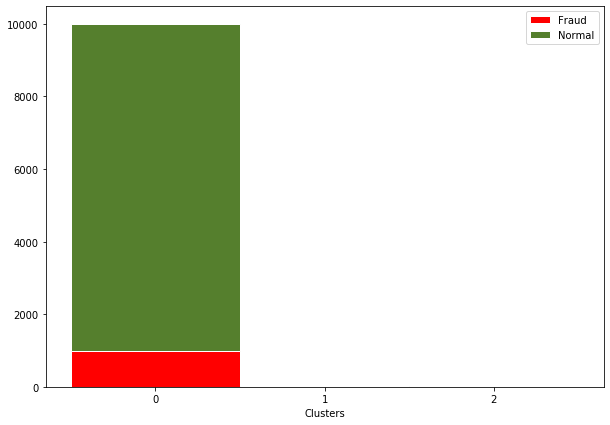

In [214]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [215]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X)
    score = silhouette_score(X, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.9990841584486653, for 4 clusters.


#### Run the K-means for 4 clusters and check if most fraud labels fall within the same cluster

In [216]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


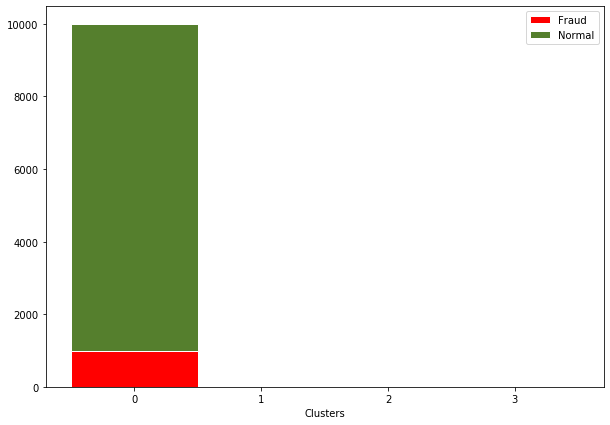

In [217]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [218]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X):
        continue
    score = silhouette_score(X, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=9, min_samples=2, producing a silhouette_score of 0


In [219]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)

In [220]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,-1,0
1,-1,0
2,-1,0
3,-1,0
4,-1,0
5,-1,0
6,-1,0
7,0,0
8,-1,0
9,0,0


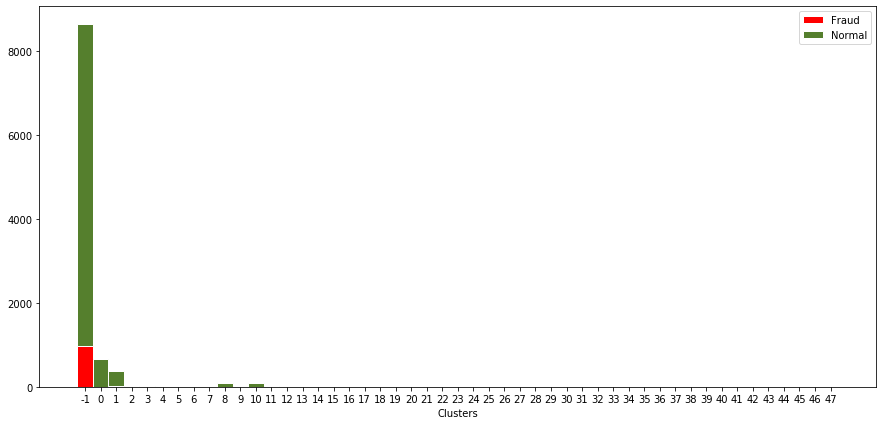

In [221]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [222]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=10, min_samples=2


In [223]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X)

In [224]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,-1,0
1,-1,0
2,-1,0
3,-1,0
4,-1,0
5,-1,0
6,-1,0
7,0,0
8,-1,0
9,0,0


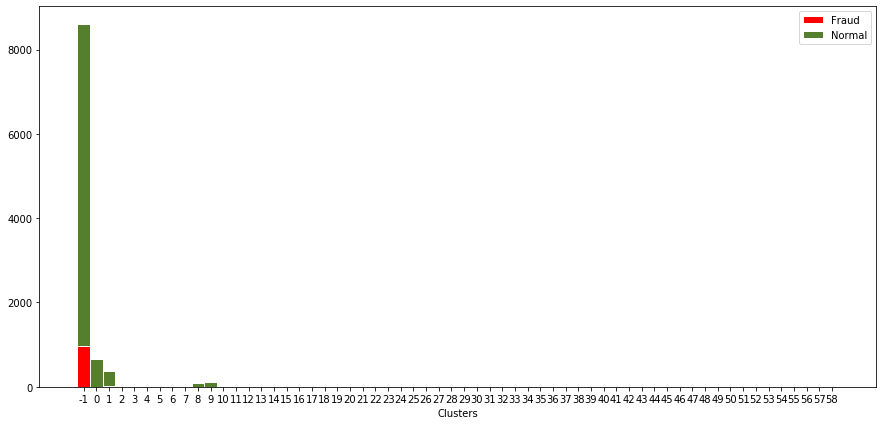

In [225]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Since our dataset is labeled, we will next try clustering using the features selected by a LinearSVC classifier.</font></p>

### 4.a Clustering without Node Embeddings (using best LinearSVC Features, Standardized)

#### Feature Selection

In [226]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

lsvc = LinearSVC(penalty="l1", dual=False, max_iter=5000).fit(X_std, y)
model = SelectFromModel(lsvc, prefit=True)

best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), model.get_support()))
print('Best Features:')
print(best_features)

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Betweenness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_5_as_Recipient', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']


In [227]:
X_new = model.transform(X_std)

#### K-means (Selecting the Number of Clusters using the Elbow Method)

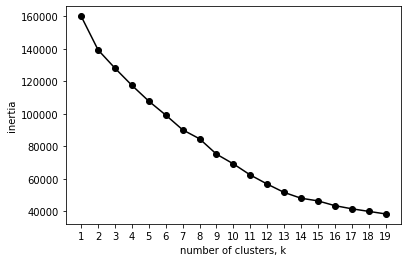

In [228]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_new)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 15 clusters.</font></p>

#### Run the K-means for 15 clusters and check if most fraud labels fall within the same cluster

In [229]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,3,0
1,6,0
2,0,0
3,0,0
4,0,0
5,13,0
6,0,0
7,0,0
8,3,0
9,3,0


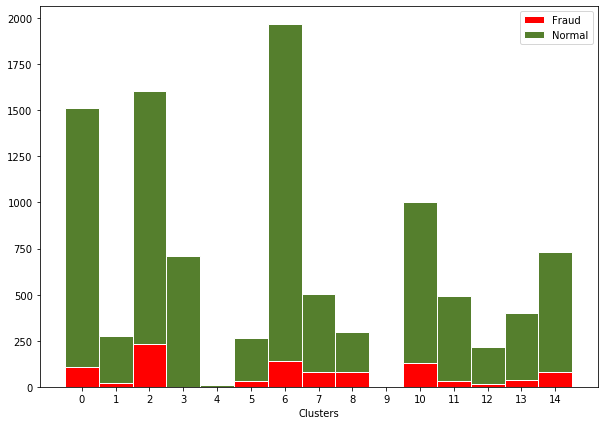

In [230]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [231]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_new)
    score = silhouette_score(X_new, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.3529569809677706, for 22 clusters.


#### Run the K-means for 22 clusters and check if most fraud labels fall within the same cluster

In [232]:
kmeans = KMeans(n_clusters=22, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,15,0
1,0,0
2,20,0
3,12,0
4,12,0
5,16,0
6,12,0
7,12,0
8,15,0
9,15,0


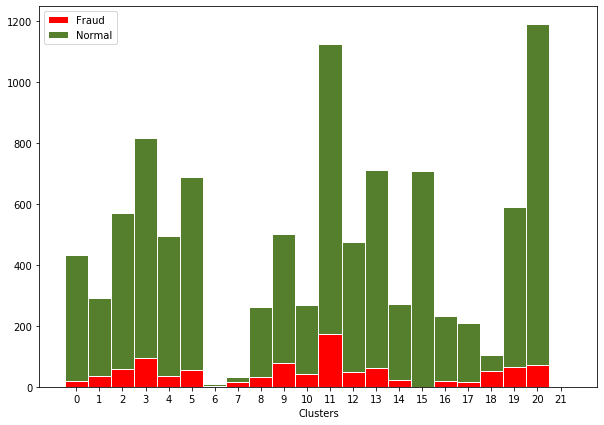

In [233]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [234]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X_new)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X_new):
        continue
    score = silhouette_score(X_new, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=9, min_samples=1, producing a silhouette_score of 0.8339562168350054


In [235]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [236]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


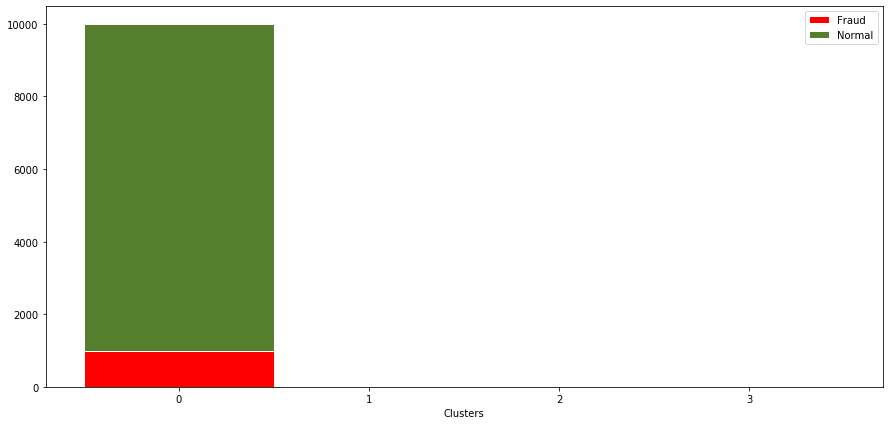

In [237]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Even though 4 clusters were formed, hyperparameter tuning using silhouette score ended up accumulating almost all accounts into a single cluster, thus explaining the high silhouette score.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [238]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X_new)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=1, min_samples=4


In [239]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [240]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,1,0
2,4,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,0,0
9,0,0


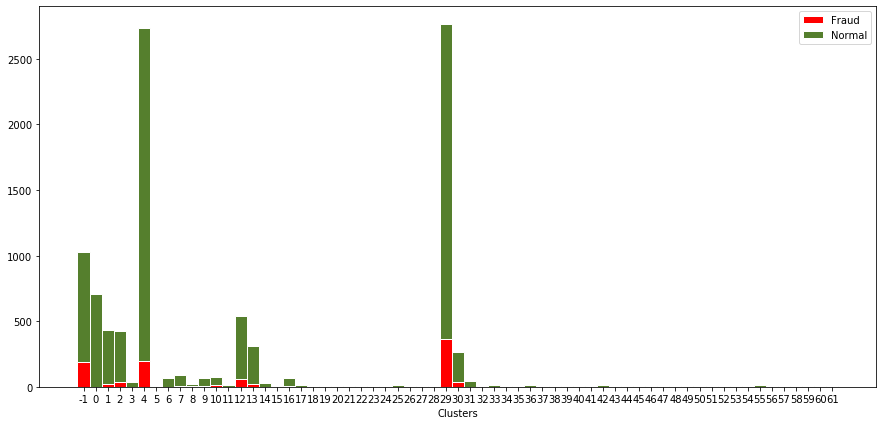

In [241]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 4.b Clustering with 20dim PyTorch BigGraph Node Embeddings (using best LinearSVC Features, Standardized)

#### Feature Selection

In [242]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

lsvc = LinearSVC(penalty="l1", dual=False, max_iter=5000).fit(X_std, y)
model = SelectFromModel(lsvc, prefit=True)

feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_20.loc[:, 'inDegree_Centrality':].columns)
best_features = list(compress(feature_labels, model.get_support()))
print('Best Features:')
print(best_features)

Best Features:
['Embedding_1', 'Embedding_2', 'Embedding_3', 'Embedding_4', 'Embedding_5', 'Embedding_6', 'Embedding_7', 'Embedding_8', 'Embedding_9', 'Embedding_10', 'Embedding_11', 'Embedding_12', 'Embedding_13', 'Embedding_14', 'Embedding_15', 'Embedding_16', 'Embedding_17', 'Embedding_18', 'Embedding_19', 'Embedding_20', 'Embedding_21', 'Embedding_22', 'Embedding_23', 'Embedding_24', 'Embedding_25', 'Embedding_26', 'Embedding_27', 'Embedding_28', 'Embedding_29', 'Embedding_30', 'Embedding_31', 'Embedding_32', 'Embedding_33', 'Embedding_34', 'Embedding_35', 'Embedding_36']


In [243]:
X_new = model.transform(X_std)

#### K-means (Selecting the Number of Clusters using the Elbow Method)

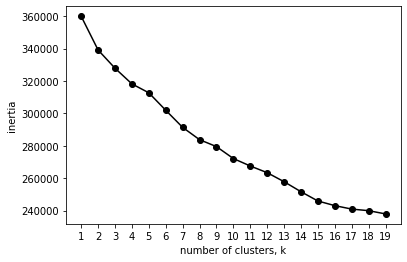

In [244]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_new)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 15 clusters.</font></p>

#### Run the K-means for 15 clusters and check if most fraud labels fall within the same cluster

In [245]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,3,0
1,12,0
2,4,0
3,7,0
4,6,0
5,1,0
6,0,0
7,5,0
8,6,0
9,5,0


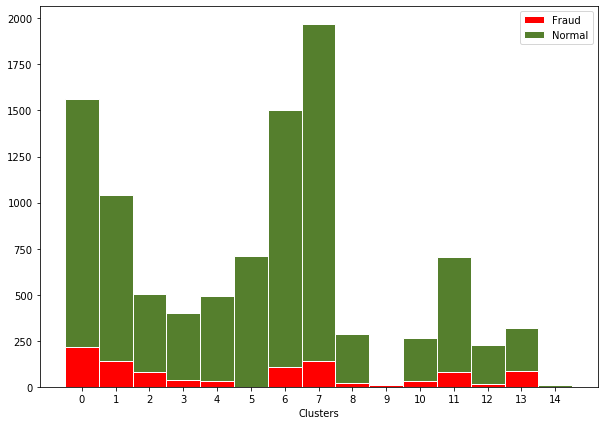

In [246]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [247]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_new)
    score = silhouette_score(X_new, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.08299864731794722, for 4 clusters.


#### Run the K-means for 4 clusters and check if most fraud labels fall within the same cluster

In [248]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,3,0
1,3,0
2,2,0
3,0,0
4,0,0
5,3,0
6,3,0
7,2,0
8,0,0
9,2,0


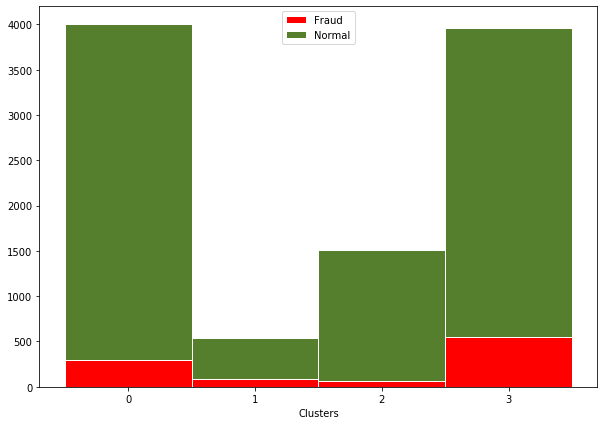

In [249]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [250]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X_new)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X_new):
        continue
    score = silhouette_score(X_new, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=10, min_samples=2, producing a silhouette_score of 0.7004596564079877


In [251]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [252]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


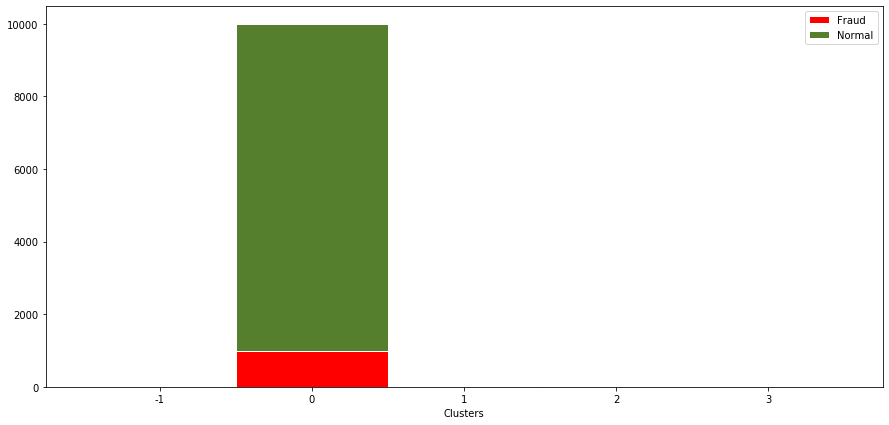

In [253]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Even though 5 clusters were formed, hyperparameter tuning using silhouette score ended up accumulating almost all accounts into a single cluster, thus explaining the high silhouette score.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [254]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X_new)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=5, min_samples=3


In [255]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [256]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,-1,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


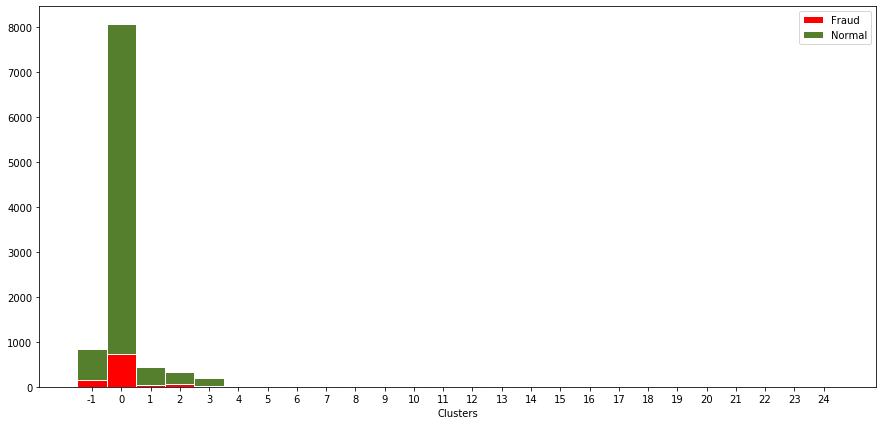

In [257]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 5.a Clustering without Node Embeddings (using best LinearSVC Features, Non-Standardized)

#### Feature Selection

In [258]:
X = labeled_accounts_df.loc[:, 'inDegree_Centrality':].to_numpy()
y = labeled_accounts_df['Fraud'].to_numpy()

lsvc = LinearSVC(penalty="l1", dual=False, max_iter=5000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)

best_features = list(compress(list(labeled_accounts_df.loc[:, 'inDegree_Centrality':].columns), model.get_support()))
print('Best Features:')
print(best_features)

Best Features:
['inDegree_Centrality', 'outDegree_Centrality', 'Closeness_Centrality', 'Transaction_Count_as_Sender', 'Transaction_Count_as_Recipient', 'Trans_PRC_of_Bin_2_as_Sender', 'Trans_PRC_of_Bin_2_as_Recipient', 'Trans_PRC_of_Bin_3_as_Sender', 'Trans_PRC_of_Bin_3_as_Recipient', 'Trans_PRC_of_Bin_4_as_Sender', 'Trans_PRC_of_Bin_4_as_Recipient', 'Trans_PRC_of_Bin_5_as_Sender', 'Trans_PRC_of_Bin_5_as_Recipient', 'Trans_PRC_of_Bin_6_as_Sender', 'Trans_PRC_of_Bin_6_as_Recipient']


In [259]:
X_new = model.transform(X)

#### K-means (Selecting the Number of Clusters using the Elbow Method)

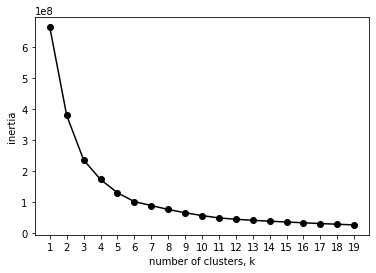

In [260]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_new)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 7 clusters.</font></p>

#### Run the K-means for 7 clusters and check if most fraud labels fall within the same cluster

In [261]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,3,0
4,3,0
5,3,0
6,3,0
7,3,0
8,3,0
9,3,0


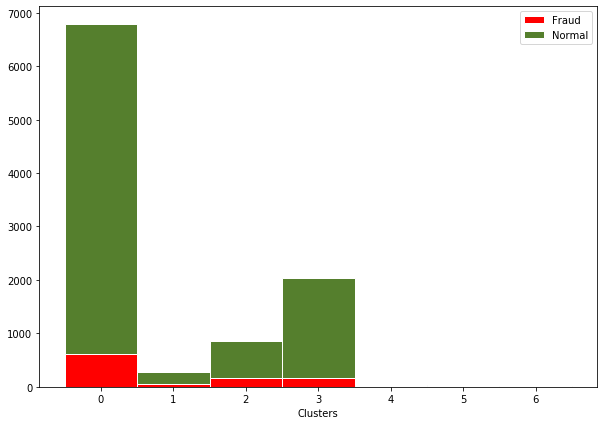

In [262]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [263]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_new)
    score = silhouette_score(X_new, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.5988396984499336, for 4 clusters.


#### Run the K-means for 4 clusters and check if most fraud labels fall within the same cluster

In [264]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


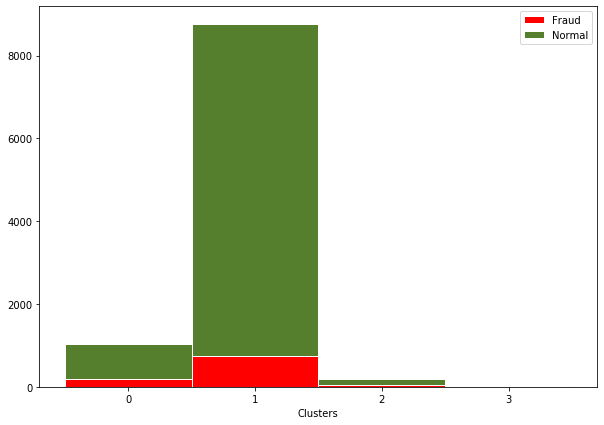

In [265]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [266]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X_new)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X_new):
        continue
    score = silhouette_score(X_new, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=10, min_samples=10, producing a silhouette_score of 0.1247859325475122


In [267]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [268]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,-1,0
1,0,0
2,1,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,3,0
9,3,0


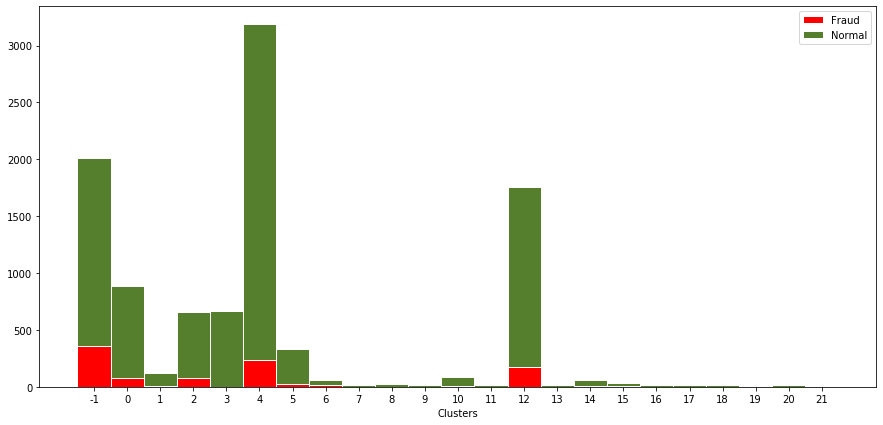

In [269]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [270]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X_new)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=10, min_samples=5


In [271]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [272]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,-1,0
1,0,0
2,1,0
3,2,0
4,2,0
5,2,0
6,2,0
7,2,0
8,3,0
9,3,0


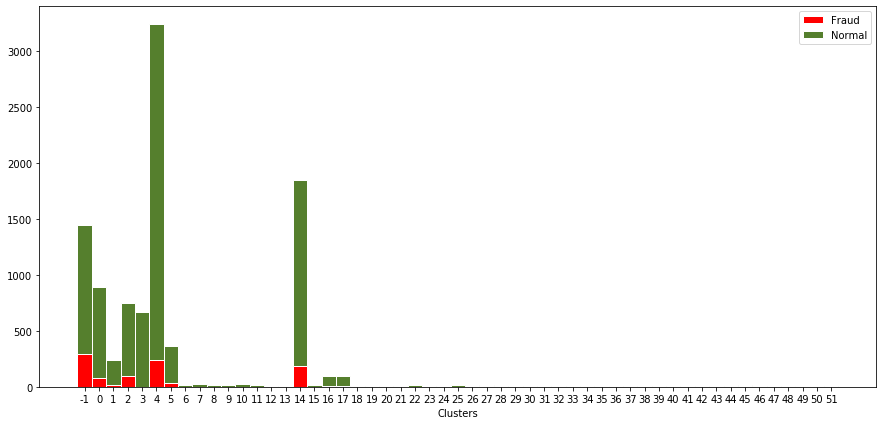

In [273]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 5.b Clustering with 20dim PyTorch BigGraph Node Embeddings (using best LinearSVC Features, Non-Standardized)

#### Feature Selection

In [274]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()

lsvc = LinearSVC(penalty="l1", dual=False, max_iter=5000).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)

feature_labels = ['Embedding_' + str(x+1) for x in range(50)] + list(pbg_df_20.loc[:, 'inDegree_Centrality':].columns)
best_features = list(compress(feature_labels, model.get_support()))
print('Best Features:')
print(best_features)

Best Features:
['Embedding_1', 'Embedding_2', 'Embedding_3', 'Embedding_4', 'Embedding_5', 'Embedding_6', 'Embedding_7', 'Embedding_8', 'Embedding_9', 'Embedding_10', 'Embedding_11', 'Embedding_12', 'Embedding_13', 'Embedding_14', 'Embedding_15', 'Embedding_16', 'Embedding_17', 'Embedding_18', 'Embedding_19', 'Embedding_20', 'Embedding_21', 'Embedding_22', 'Embedding_23', 'Embedding_25', 'Embedding_26', 'Embedding_27', 'Embedding_28', 'Embedding_29', 'Embedding_31', 'Embedding_33', 'Embedding_34', 'Embedding_35', 'Embedding_36']


In [275]:
X_new = model.transform(X)

#### K-means (Selecting the Number of Clusters using the Elbow Method)

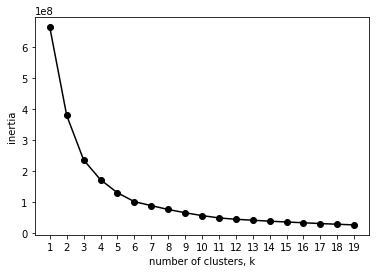

In [276]:
ks = range(1, 20)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_new)   
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">The elbow point seems to be at around 8 clusters.</font></p>

#### Run the K-means for 8 clusters and check if most fraud labels fall within the same cluster

In [277]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,6,0
1,2,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,2,0
8,2,0
9,2,0


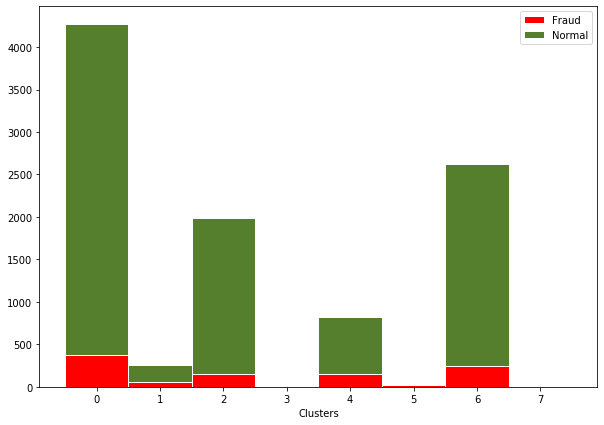

In [278]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### K-means (Selecting the Number of Clusters using Silhouette Score)

In [279]:
best_score = 0

for n_clusters in range(4, 30):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_new)
    score = silhouette_score(X_new, preds)
    if score > best_score:
        best_score = score
        best_n_clusters = n_clusters
    
print("The best silhouette score is {}, for {} clusters.".format(best_score, best_n_clusters))

The best silhouette score is 0.621890831376125, for 4 clusters.


#### Run the K-means for 4 clusters and check if most fraud labels fall within the same cluster

In [280]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_new)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


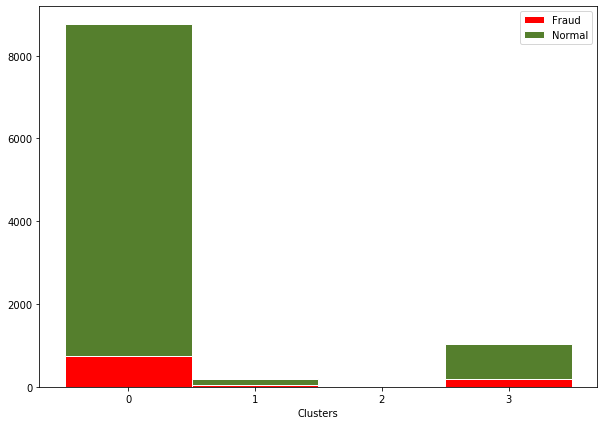

In [281]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(10,7))
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Silhouette Score for Hyperparameter tuning)

In [282]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_score = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1])  
    preds = dbscan.fit_predict(X_new)
    
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
    
    # Avoid cases where silhouette score cannot be calculated
    if len(cluster_names) <= 1 or len(cluster_names) >= len(X_new):
        continue
    score = silhouette_score(X_new, preds)

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70): 
        if (score > best_score):
            best_score = score
            best_eps = r[0]
            best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples)+', producing a silhouette_score of '+str(best_score))

Best parameters are: eps=10, min_samples=9, producing a silhouette_score of 0.05151768499331877


In [283]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [284]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,4,0
1,-1,0
2,0,0
3,-1,0
4,0,0
5,0,0
6,0,0
7,1,0
8,2,0
9,1,0


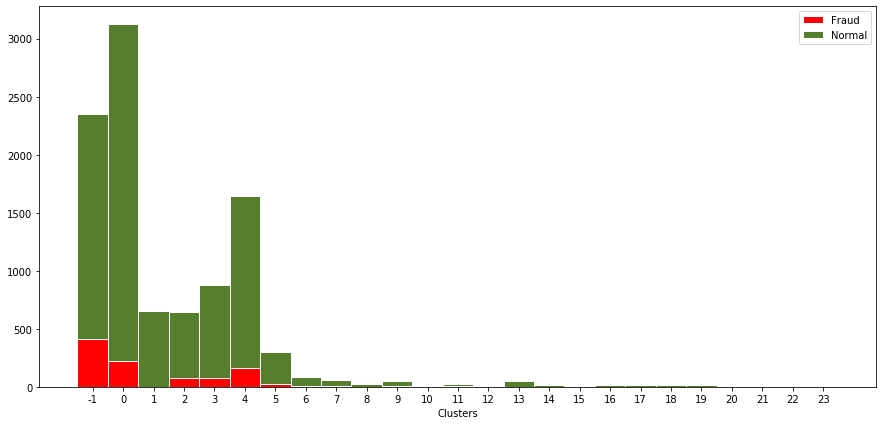

In [285]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">No single "Fraud" cluster has been formed.</font></p>

#### DBSCAN (Using Fraud Percentages within Cluster for Hyperparameter tuning)

In [286]:
eps = list(range(1,11))
min_samples = list(range(1,11))
best_fraud_prc = 0

# Loop through the permutations of (eps,min_samples)
for r in product(eps, min_samples):
    dbscan = DBSCAN(eps=r[0], min_samples=r[1]).fit(X_new)
    clusters_v_labels = np.vstack((dbscan.labels_, y)).T
    clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
    clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
    cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()

    # Avoid cases where DBSCAN tends to group all data points on 1-2 clusters OR cases of extremely high number of clusters 
    if (len(cluster_names) > 3 and len(cluster_names) < 70):
        for i in cluster_names:
            try:
                fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                fraud_count = 0
            try:
                normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
            except IndexError:
                normal_count = 0

            fraud_prc = fraud_count / (fraud_count + normal_count)
            # Check for a high percentage of frauds within a cluster
            if (fraud_prc > best_fraud_prc and fraud_count > 50):
                best_fraud_prc = fraud_prc
                best_eps = r[0]
                best_min_samples = r[1]
                
print('Best parameters are: eps='+str(best_eps)+', min_samples='+str(best_min_samples))

Best parameters are: eps=10, min_samples=5


In [287]:
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(X_new)

In [288]:
clusters_v_labels = np.vstack((dbscan.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']
clusters_v_labels_df.head(10)

,Cluster_Name,Fraud_Label
0,0,0
1,-1,0
2,1,0
3,-1,0
4,1,0
5,1,0
6,1,0
7,2,0
8,3,0
9,2,0


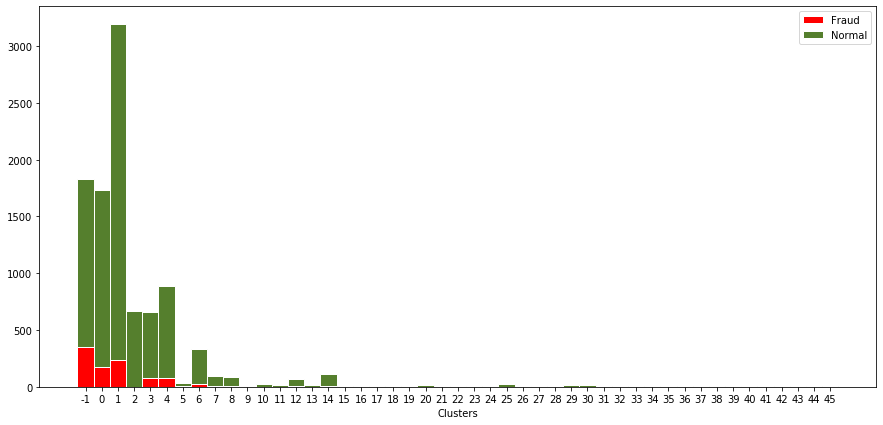

In [289]:
cluster_names = clusters_v_labels_df['Cluster_Name'].sort_values().unique().tolist()
r = list(range(len(cluster_names)))

bars1 = list()
bars2 = list()

# Populate lists of counts for each cluster
for i in cluster_names:
    try:
        fraud_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==1) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        fraud_count = 0
    try:
        normal_count = clusters_v_labels_df.loc[(clusters_v_labels_df['Fraud_Label']==0) & (clusters_v_labels_df['Cluster_Name']==i), 'Cluster_Name'].value_counts().tolist()[0]
    except IndexError:
        normal_count = 0
        
    bars1.append(fraud_count)
    bars2.append(normal_count)

plt.figure(figsize=(15,7)) 
plt.bar(r, bars1, color='#ff0000', edgecolor='white', width=1)
plt.bar(r, bars2, bottom=bars1, color='#557f2d', edgecolor='white', width=1)
plt.legend(["Fraud", "Normal"])
plt.xticks(r, cluster_names)
plt.xlabel("Clusters")
plt.show()

<p style="border:3px; border-style:solid; border-color:#00EE00; padding: 1em;"><font size="3">Again, no single "Fraud" cluster has been formed.</font></p>

### 6. t-SNE Visualization of clusters

#### On standardized features with 20dim PyTorch BigGraph Node Embeddings using K-means with the elbow method)

In [290]:
X = np.array(pbg_df_20['Embeddings'].values.tolist())
X = np.hstack((X, pbg_df_20.loc[:, 'inDegree_Centrality':]))
y = pbg_df_20['Fraud'].to_numpy()
X_std = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=12, random_state=0).fit(X_std)
# Create dataframe with cluster names and fraud labels
clusters_v_labels = np.vstack((kmeans.labels_, y)).T
clusters_v_labels_df = pd.DataFrame(clusters_v_labels)
clusters_v_labels_df.columns = ['Cluster_Name', 'Fraud_Label']

#### Run t-SNE (2D & 3D) for different values of perplexity and number of iterations

In [291]:
X_embedded_3_30_5000 = TSNE(n_components=3, init='random', random_state=0, perplexity=30, n_iter=5000).fit_transform(X_std)
X_embedded_3_50_5000 = TSNE(n_components=3, init='random', random_state=0, perplexity=50, n_iter=5000).fit_transform(X_std)
X_embedded_3_30_1000 = TSNE(n_components=3, init='random', random_state=0, perplexity=30, n_iter=1000).fit_transform(X_std)
X_embedded_3_50_1000 = TSNE(n_components=3, init='random', random_state=0, perplexity=50, n_iter=1000).fit_transform(X_std)

X_embedded_2_30_5000 = TSNE(n_components=2, init='random', random_state=0, perplexity=30, n_iter=5000).fit_transform(X_std)
X_embedded_2_50_5000 = TSNE(n_components=2, init='random', random_state=0, perplexity=50, n_iter=5000).fit_transform(X_std)
X_embedded_2_30_1000 = TSNE(n_components=2, init='random', random_state=0, perplexity=30, n_iter=1000).fit_transform(X_std)
X_embedded_2_50_1000 = TSNE(n_components=2, init='random', random_state=0, perplexity=50, n_iter=1000).fit_transform(X_std)

#### Create lists for boolean indexing on cluster and fraud coloring when plotting

In [292]:
colors_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan', 'y', 'slategray', 'mediumspringgreen', 'black']

cluster0 = clusters_v_labels_df.Cluster_Name == 0
cluster1 = clusters_v_labels_df.Cluster_Name == 1
cluster2 = clusters_v_labels_df.Cluster_Name == 2
cluster3 = clusters_v_labels_df.Cluster_Name == 3
cluster4 = clusters_v_labels_df.Cluster_Name == 4
cluster5 = clusters_v_labels_df.Cluster_Name == 5
cluster6 = clusters_v_labels_df.Cluster_Name == 6
cluster7 = clusters_v_labels_df.Cluster_Name == 7
cluster8 = clusters_v_labels_df.Cluster_Name == 8
cluster9 = clusters_v_labels_df.Cluster_Name == 9
cluster10 = clusters_v_labels_df.Cluster_Name == 10
cluster11 = clusters_v_labels_df.Cluster_Name == 11

fraud0 = clusters_v_labels_df.Fraud_Label == 0
fraud1 = clusters_v_labels_df.Fraud_Label == 1

cluster_list = [cluster0, cluster1, cluster2, cluster3, cluster4, cluster5, cluster6, cluster7, cluster8, cluster9, cluster10, cluster11]

#### 3D Scatterplot on clusters

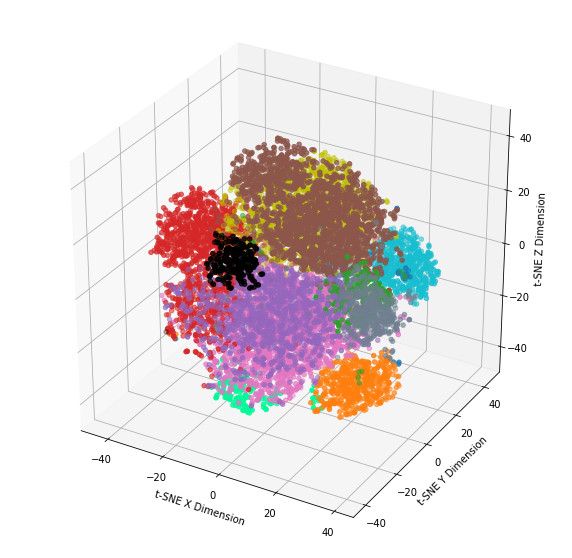

In [293]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(12):
    ax.scatter(X_embedded_3_30_1000[cluster_list[i],0], X_embedded_3_30_1000[cluster_list[i],1], X_embedded_3_30_1000[cluster_list[i],2], c=colors_list[i], marker='o')

ax.set_xlabel('t-SNE X Dimension')
ax.set_ylabel('t-SNE Y Dimension')
ax.set_zlabel('t-SNE Z Dimension')

plt.show()

#### 3D Scatterplot on frauds

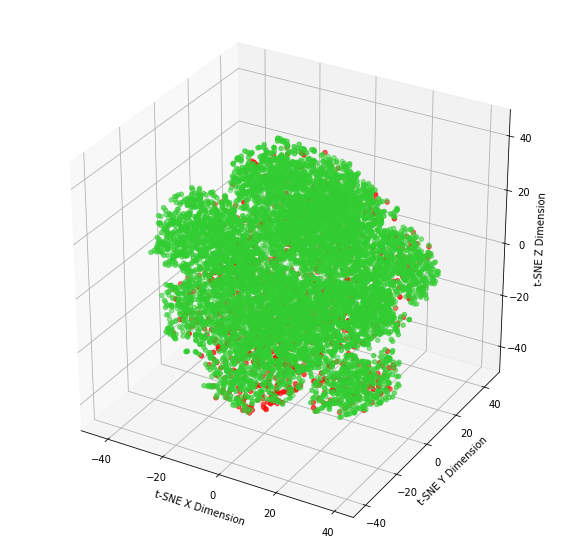

In [294]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_embedded_3_30_1000[fraud0,0], X_embedded_3_30_1000[fraud0,1], X_embedded_3_30_1000[fraud0,2], c='limegreen', marker='o')
ax.scatter(X_embedded_3_30_1000[fraud1,0], X_embedded_3_30_1000[fraud1,1], X_embedded_3_30_1000[fraud1,2], c='red', marker='o')

ax.set_xlabel('t-SNE X Dimension')
ax.set_ylabel('t-SNE Y Dimension')
ax.set_zlabel('t-SNE Z Dimension')

plt.show()

#### 2D Scatterplot on clusters

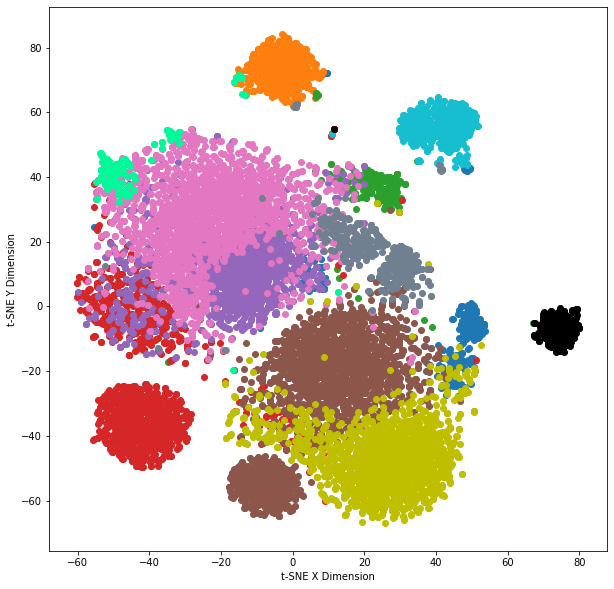

In [295]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i in range(12):
    ax.scatter(X_embedded_2_30_1000[cluster_list[i],0], X_embedded_2_30_1000[cluster_list[i],1], c=colors_list[i], marker='o')

ax.set_xlabel('t-SNE X Dimension')
ax.set_ylabel('t-SNE Y Dimension')

plt.show()

#### 2D Scatterplot on frauds

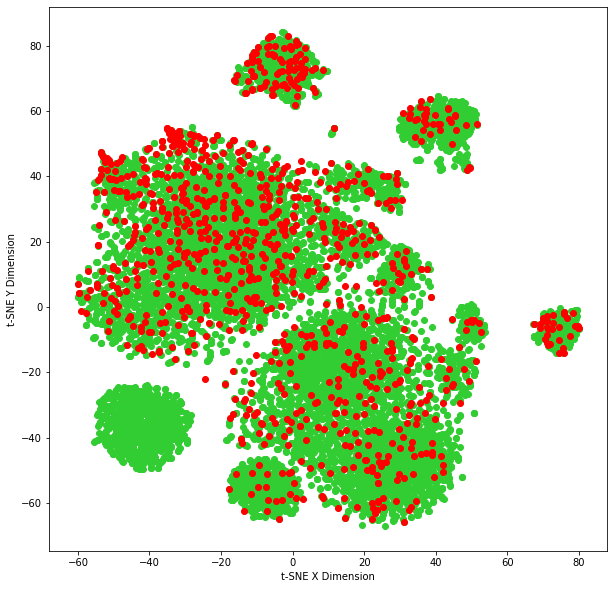

In [296]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

ax.scatter(X_embedded_2_30_1000[fraud0,0], X_embedded_2_30_1000[fraud0,1], c='limegreen', marker='o')
ax.scatter(X_embedded_2_30_1000[fraud1,0], X_embedded_2_30_1000[fraud1,1], c='red', marker='o')
    
ax.set_xlabel('t-SNE X Dimension')
ax.set_ylabel('t-SNE Y Dimension')

plt.show()

## Part 3 - Preprocessing for ClusterGCN

#### Fix ClusterGCN issue with (int) Nodes

In [297]:
main_df_gcn = main_df.copy()
labeled_accounts_df_gcn = labeled_accounts_df.copy()
main_df_gcn['Source_Account'] = 'A' + main_df_gcn['Source_Account'].astype(str)
main_df_gcn['Destination_Account'] = 'A' + main_df_gcn['Destination_Account'].astype(str)
labeled_accounts_df_gcn['Account'] = 'A' + labeled_accounts_df_gcn['Account'].astype(str)

#### Shuffle the dataframe

In [298]:
labeled_accounts_df_gcn = labeled_accounts_df_gcn.sample(frac=1).reset_index(drop=True)

#### Create Node Features File

In [299]:
node_feats = labeled_accounts_df_gcn.iloc[:,3:].to_numpy()

filePath = "fraud-feats.npy"
if os.path.exists(filePath):
    os.remove(filePath)
np.save(filePath, node_feats)

#### Create Class Map File

In [300]:
filePath = "fraud-class_map.json"
if os.path.exists(filePath):
    os.remove(filePath)

f = open(filePath,"w+")
f.write("{")
for index, row in labeled_accounts_df_gcn[['Account', 'Fraud']].iterrows():
    f.write("\"" + str(row['Account']) + "\": " + str(row['Fraud']) + ", ")
f.seek(0, os.SEEK_END)
f.seek(f.tell() - 2, os.SEEK_SET)
f.truncate()
f.write("}")
f.close()

#### Create Node Id Map File

In [301]:
filePath = "fraud-id_map.json"
if os.path.exists(filePath):
    os.remove(filePath)

f = open(filePath,"w+")
f.write("{")
for index, row in labeled_accounts_df_gcn[['Account', 'id']].iterrows():
    f.write("\"" + str(row['Account']) + "\": " + str(row['id']) + ", ")
f.seek(0, os.SEEK_END)
f.seek(f.tell() - 2, os.SEEK_SET)
f.truncate()
f.write("}")
f.close()

#### Create Graph File - Preprocessing

In [302]:
test_length = val_length = floor(len(labeled_accounts_df_gcn) * 0.15)
labeled_accounts_df_gcn['test'] = 'false'
labeled_accounts_df_gcn['test'][:test_length] = 'true'
labeled_accounts_df_gcn['val'] = 'false'
labeled_accounts_df_gcn['val'][test_length:test_length + val_length] = 'true'

In [303]:
# Shuffle the dataframe
labeled_accounts_df_gcn = labeled_accounts_df_gcn.sample(frac=1).reset_index(drop=True)

In [304]:
account_to_ids_dict = labeled_accounts_df_gcn.set_index('Account')['id'].to_dict()

#### Create the file - Method 1

In [305]:
filePath = "fraud-G.json"
if os.path.exists(filePath):
    os.remove(filePath)

f = open(filePath,"w+")
f.write("{\"directed\": true, \"graph\": {}, \"nodes\": [")
for index, row in labeled_accounts_df_gcn[['Account', 'test', 'val']].iterrows():
    f.write("{\"test\": " + str(row['test']) + ", \"id\": \"" + str(row['Account']) + "\", \"val\": " + str(row['val']) + "}, ")
f.seek(0, os.SEEK_END)
f.seek(f.tell() - 2, os.SEEK_SET)
f.truncate()
f.write("], \"links\": [")
for index, row in main_df_gcn[['Source_Account', 'Destination_Account', 'Amount']].iterrows():
    f.write("{\"source\": " + str(account_to_ids_dict[str(row['Source_Account'])]) + ", \"target\": " + str(account_to_ids_dict[str(row['Destination_Account'])]) + ", \"weight\": " + str(row['Amount']) + "}, ")
f.seek(0, os.SEEK_END)
f.seek(f.tell() - 2, os.SEEK_SET)
f.truncate()
f.write("], \"multigraph\": false}")
f.close()

#### Create the file - Method 2 // Throws Errors

In [306]:
# import networkx as nx
# from networkx.readwrite import json_graph
# import json

In [307]:
# # Load edgelist file
# fh=open("graph_10K.edgelist", 'rb')
# G=nx.read_weighted_edgelist(fh, create_using=nx.DiGraph())

In [308]:
# tmp_labeled_accounts_df = labeled_accounts_df_gcn[['Account', 'test']]
# tmp_labeled_accounts_df.set_index('Account',inplace=True)
# tmp_dict_1 = tmp_labeled_accounts_df.to_dict()['test']

# tmp_labeled_accounts_df = labeled_accounts_df_gcn[['Account', 'val']]
# tmp_labeled_accounts_df.set_index('Account',inplace=True)
# tmp_dict_2 = tmp_labeled_accounts_df.to_dict()['val']

In [309]:
# nx.set_node_attributes(G, 'test', tmp_dict_1)
# nx.set_node_attributes(G, 'val', tmp_dict_2)

In [310]:
# filePath = "fraud-G.json"
# if os.path.exists(filePath):
#     os.remove(filePath)

# with open(filePath, 'w') as outfile:
#     outfile.write(json.dumps(json_graph.node_link_data(G)))